<div style="text-align: center;">
  <img src="https://github.com/Hack-io-Data/Imagenes/blob/main/01-LogosHackio/logo_naranja@4x.png?raw=true" alt="esquema" />
</div>

# Preprocesamiento de Datos para un Modelo de Clasificación

Nuestro equipo de riesgo ha identificado la necesidad de construir un modelo de clasificación para detectar transacciones potencialmente fraudulentas o anómalas. El éxito de este modelo permitirá identificar patrones en los datos y reducir pérdidas económicas para nuestros clientes y la empresa. Tu trabajo para hoy será preparar los datos proporcionados para desarrollar un modelo de clasificación que prediga la probabilidad de que una transacción sea “Normal” o “Anómala”, basándose en las características de las transacciones. Dentro de las tareas que tienes que realizar hoy deben estar incluidas las siguientes: 


1. **Análisis exploratorio de datos (EDA):**

   - Visualizar la distribución de las principales variables.

   - Explorar relaciones entre las características y la variable objetivo (`TransactionStatus`).


2. **Limpieza de datos:**

   - Identificar y tratar valores nulos.

   - Eliminar duplicados si existen.

   - Asegurar que las variables tienen el tipo de dato correcto.

   - etc. 

3. **Transformación de variables:**

   - Normalizar o escalar variables numéricas según sea necesario.

   - Codificar variables categóricas con técnicas como One-Hot Encoding, Target Encoding u Ordinal Encoding, según corresponda.

   - Crear variables derivadas útiles, como:

     - Frecuencia de transacciones de cada cliente.

     - Diferencia de tiempo entre transacciones consecutivas.

     - Ratio entre el saldo posterior y el monto de la transacción.

## Datos Proporcionados

El archivo de datos que analizarán contiene transacciones reales registradas por una compañia. A continuación, se describen las principales columnas que deberán preprocesar:

| Columna               | Descripción                                                                                     |
|-----------------------|-------------------------------------------------------------------------------------------------|
| `transaction_id`      | Identificador único de la transacción.                                                         |
| `customer_id`         | Identificador único del cliente que realizó la transacción.                                    |
| `merchant_id`         | Identificador único del comercio donde se realizó la transacción.                              |
| `amount`              | Monto de la transacción (en la moneda correspondiente).                                        |
| `transaction_time`    | Fecha y hora exacta en la que ocurrió la transacción.                                          |
| `is_fraudulent`       | Indicador de si la transacción fue fraudulenta (1: Sí, 0: No).                                 |
| `card_type`           | Tipo de tarjeta utilizada para la transacción (Visa, MasterCard, American Express, Discover).  |
| `location`            | Ubicación (ciudad o región) donde se realizó la transacción.                                   |
| `purchase_category`   | Categoría de la compra (por ejemplo, Gas Station, Online Shopping, Retail, etc.).              |
| `customer_age`        | Edad del cliente en el momento de la transacción.                                              |
| `transaction_description` | Descripción breve de la transacción, usualmente incluye el comercio asociado.              |


In [284]:
# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np

# Importamos las clases creadas para hace el EDA
# -----------------------------------------------------------------------
from src import soporte_logistica_preprocesamiento as sl
from src import soporte_encoding_logistica as se

# Ignorar warnings
# -----------------------------------------------------------------------
import warnings
warnings.filterwarnings("ignore")

from src.SupportOutliers import (
    plot_outliers_univariados,
    identificar_outliers_iqr,
    identificar_outliers_z,
    visualizar_outliers_bivariados,
    explorar_outliers_if,
    explorar_outliers_lof
)

from src.SupportPreProcesamiento import (
    exploracion_dataframe
)
import pickle
from category_encoders import TargetEncoder
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler, RobustScaler
from itertools import product , combinations
from sklearn.experimental import enable_iterative_imputer  # Necesario para habilitar IterativeImputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

In [285]:
df = pd.read_csv("datos/financial_data.csv")

In [286]:
df.sample()

,transaction_id,customer_id,merchant_id,amount,transaction_time,is_fraudulent,card_type,location,purchase_category,customer_age,transaction_description
8115,8116,1077,2061,3090.3,2023-01-01 02:15:15,0,American Express,City-24,Online Shopping,58,Purchase at Merchant-2061


In [287]:
# leemos el dataframe
#exploracion_datos(df)
exploracion_dataframe(df,"is_fraudulent")

El número de datos es 10000 y el de columnas es 11

 ..................... 

Los duplicados que tenemos en el conjunto de datos son: 0

 ..................... 

Los nulos que tenemos en el conjunto de datos son:


,%_nulos



 ..................... 

Los tipos de las columnas son:


,tipo_dato
transaction_id,int64
customer_id,int64
merchant_id,int64
amount,float64
transaction_time,object
is_fraudulent,int64
card_type,object
location,object
purchase_category,object
customer_age,int64



 ..................... 

Los valores que tenemos para las columnas categóricas son: 
La columna TRANSACTION_TIME tiene las siguientes valore únicos:


,count
transaction_time,
2023-01-01 02:46:23,1
2023-01-01 02:46:22,1
2023-01-01 02:46:21,1
2023-01-01 02:46:20,1
2023-01-01 02:46:19,1


La columna CARD_TYPE tiene las siguientes valore únicos:


,count
card_type,
Discover,2633
American Express,2494
Visa,2490
MasterCard,2383


La columna LOCATION tiene las siguientes valore únicos:


,count
location,
City-7,223
City-40,221
City-14,218
City-32,218
City-41,218


La columna PURCHASE_CATEGORY tiene las siguientes valore únicos:


,count
purchase_category,
Travel,1694
Groceries,1692
Gas Station,1666
Retail,1661
Online Shopping,1651


La columna TRANSACTION_DESCRIPTION tiene las siguientes valore únicos:


,count
transaction_description,
Purchase at Merchant-2016,120
Purchase at Merchant-2078,120
Purchase at Merchant-2055,118
Purchase at Merchant-2019,117
Purchase at Merchant-2057,117


In [288]:
df.head()

,transaction_id,customer_id,merchant_id,amount,transaction_time,is_fraudulent,card_type,location,purchase_category,customer_age,transaction_description
0,1,1082,2027,5758.59,2023-01-01 00:00:00,0,MasterCard,City-30,Gas Station,43,Purchase at Merchant-2027
1,2,1015,2053,1901.56,2023-01-01 00:00:01,1,Visa,City-47,Online Shopping,61,Purchase at Merchant-2053
2,3,1004,2035,1248.86,2023-01-01 00:00:02,1,MasterCard,City-6,Gas Station,57,Purchase at Merchant-2035
3,4,1095,2037,7619.05,2023-01-01 00:00:03,1,Discover,City-6,Travel,59,Purchase at Merchant-2037
4,5,1036,2083,1890.10,2023-01-01 00:00:04,1,MasterCard,City-34,Retail,36,Purchase at Merchant-2083


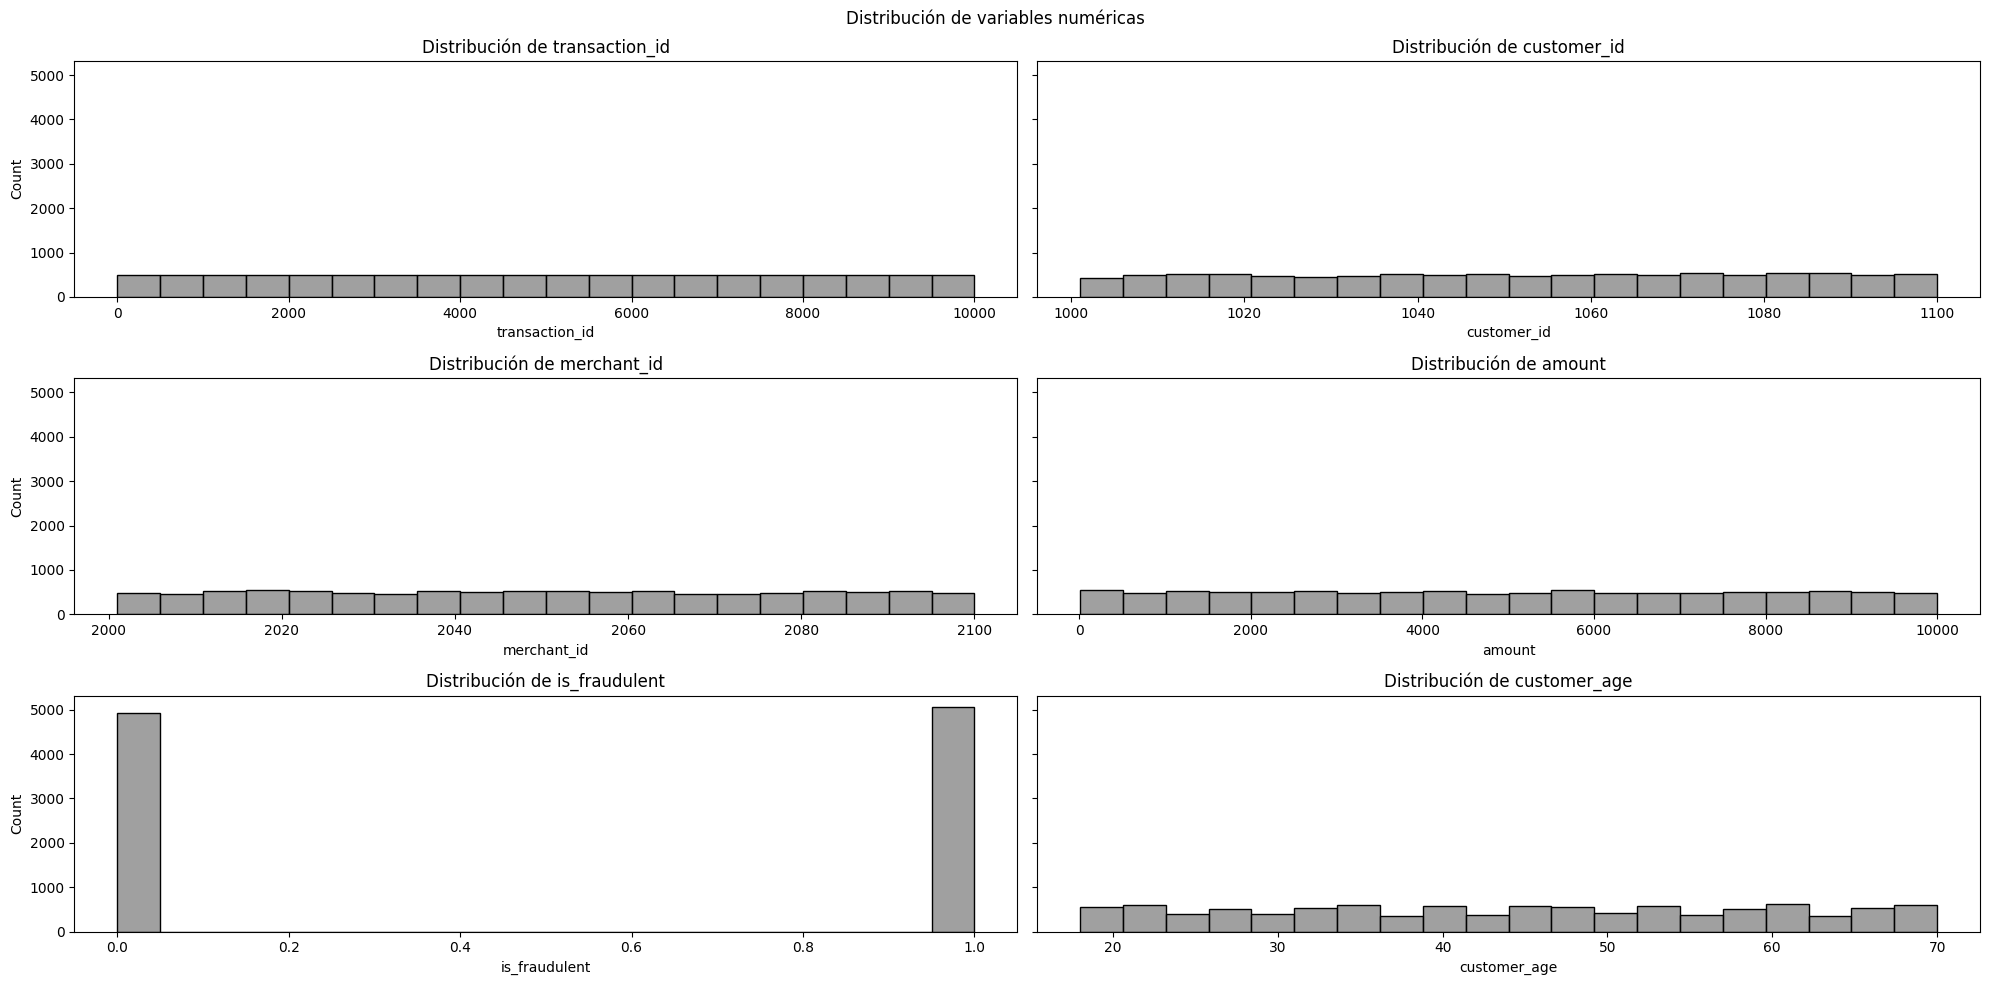

In [289]:
# Crear una instancia de la clase y llamar a los métodos
visualizador =sl.Visualizador(df)

# exploramos la distribución de las variables numéricas
visualizador.plot_numericas()

### Sobre la gráfica
- Quitando la variable respuesta
- La distribución parece igual para todas

# Plot categoricas
- Quitamos transaction time porque tiene demasiados

In [290]:
df.columns

Index(['transaction_id', 'customer_id', 'merchant_id', 'amount',
       'transaction_time', 'is_fraudulent', 'card_type', 'location',
       'purchase_category', 'customer_age', 'transaction_description'],
      dtype='object')

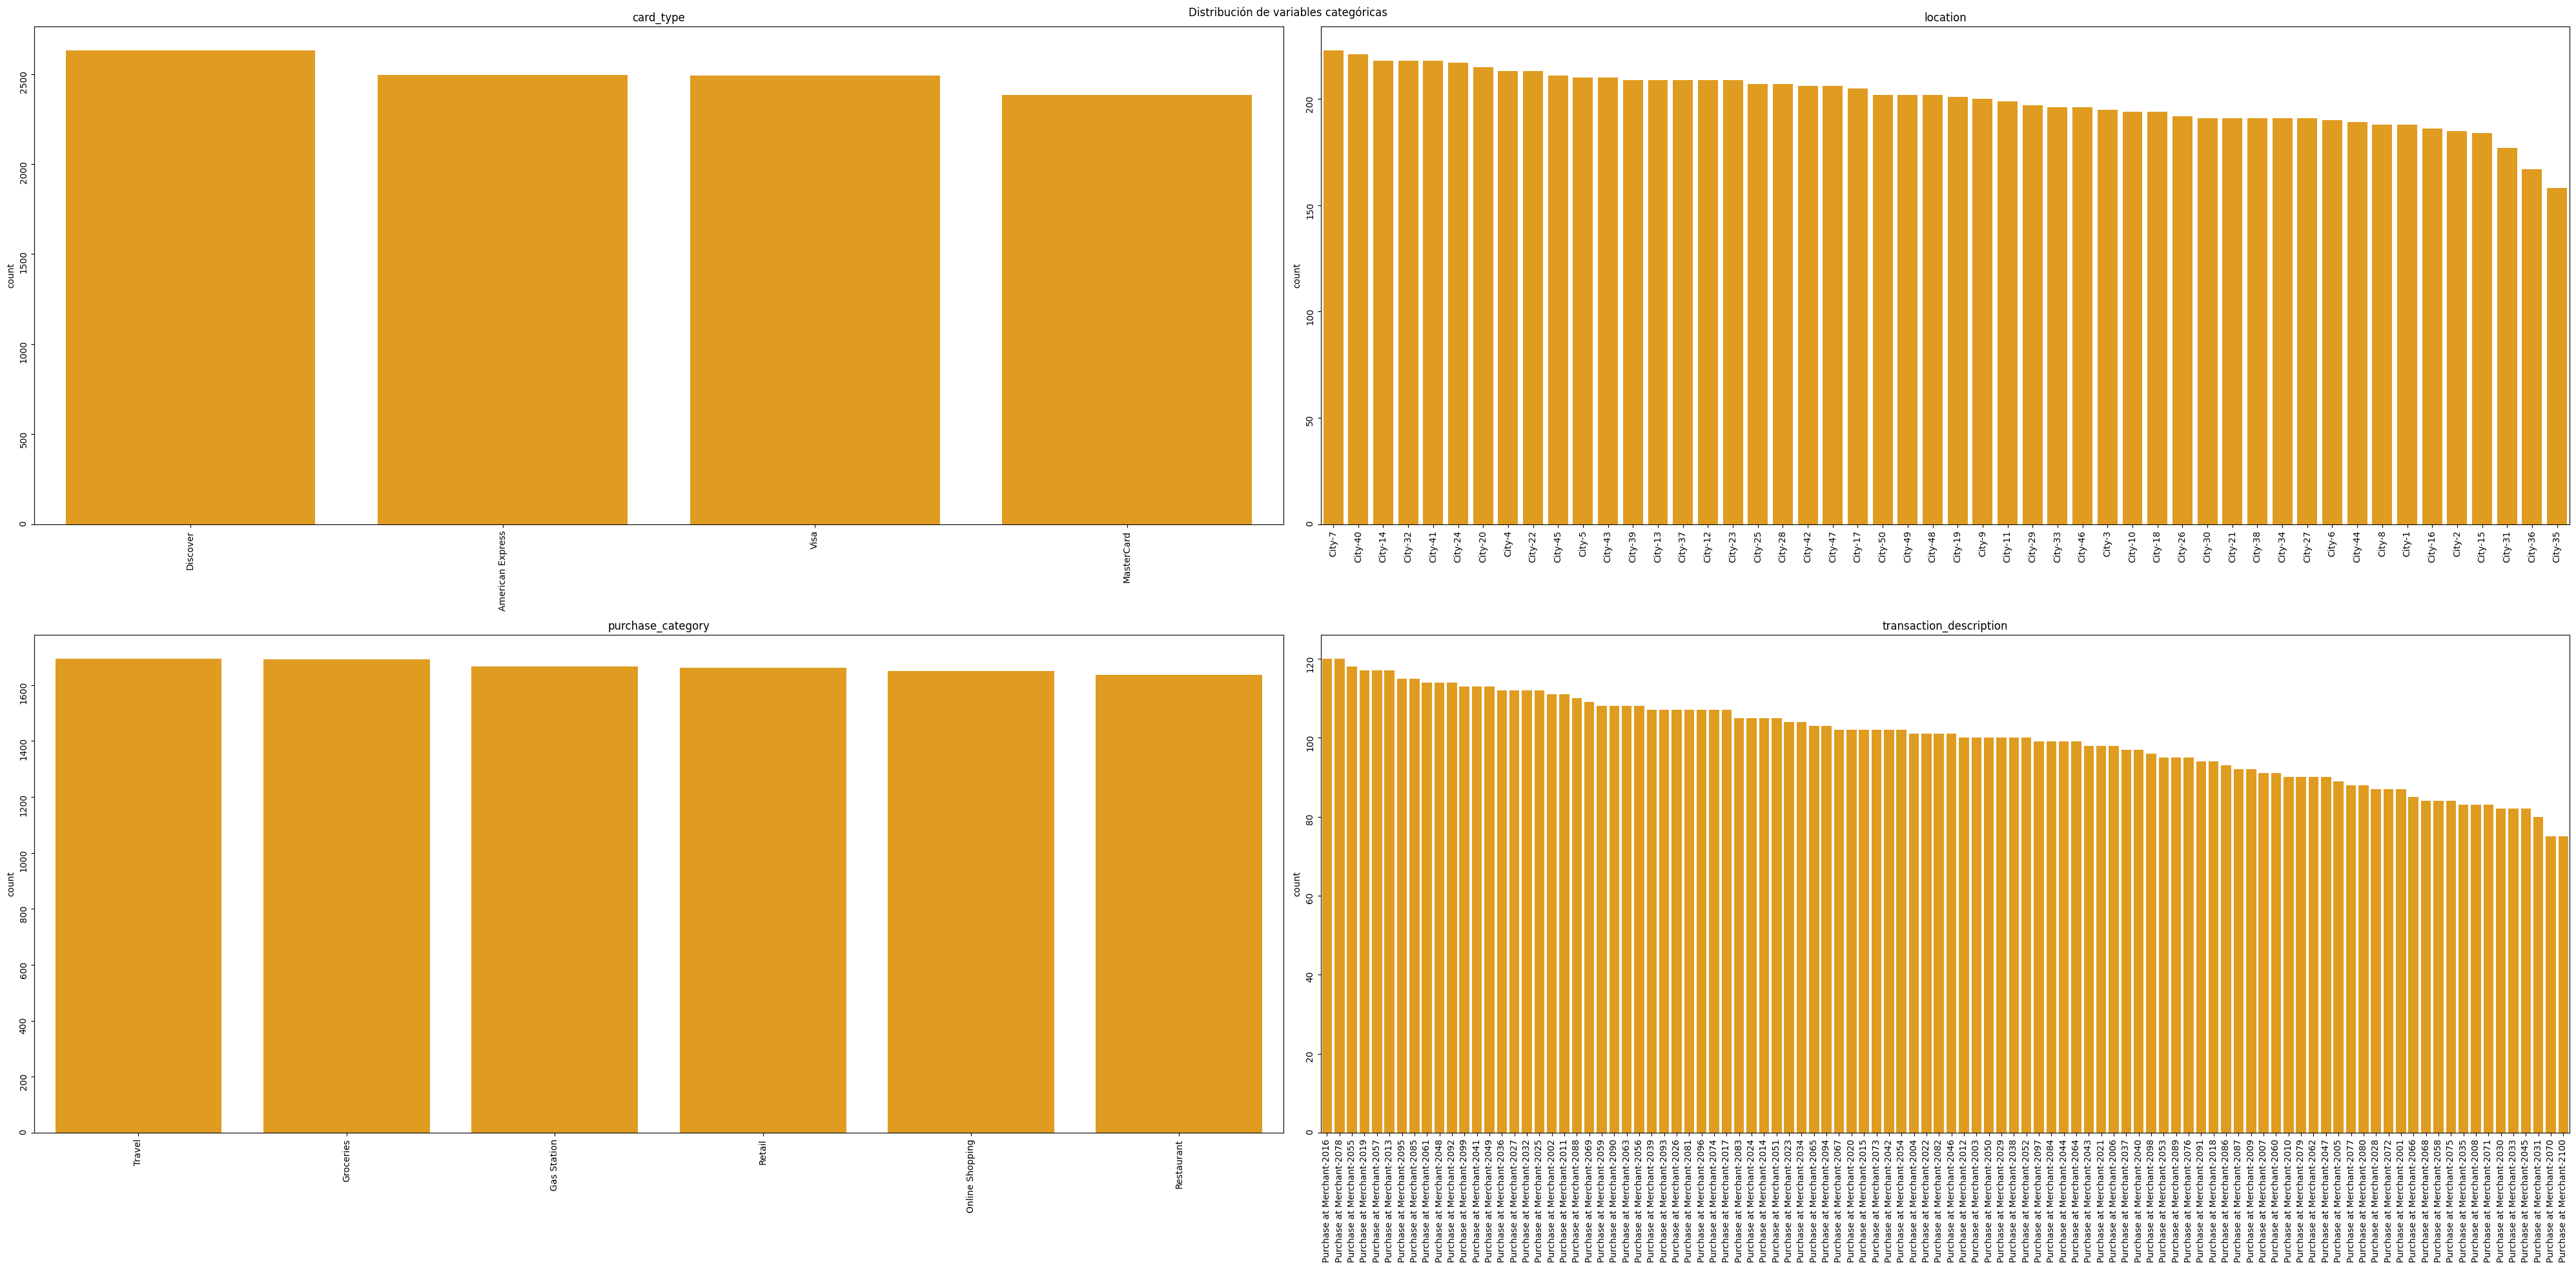

In [291]:
# Crear una instancia de la clase y llamar a los métodos
visualizador2 =sl.Visualizador(df[['transaction_id', 'customer_id', 'merchant_id', 'amount',
                                    'is_fraudulent', 'card_type', 'location',
                                    'purchase_category', 'customer_age', 'transaction_description']])

# evaluamos la distribución de las variables categóricas
visualizador2.plot_categoricas(color = "orange",tamano_grafica=(40,20))

PURCHASE STATUS y PURCHASE_CATEGORY

# Ver Outliers

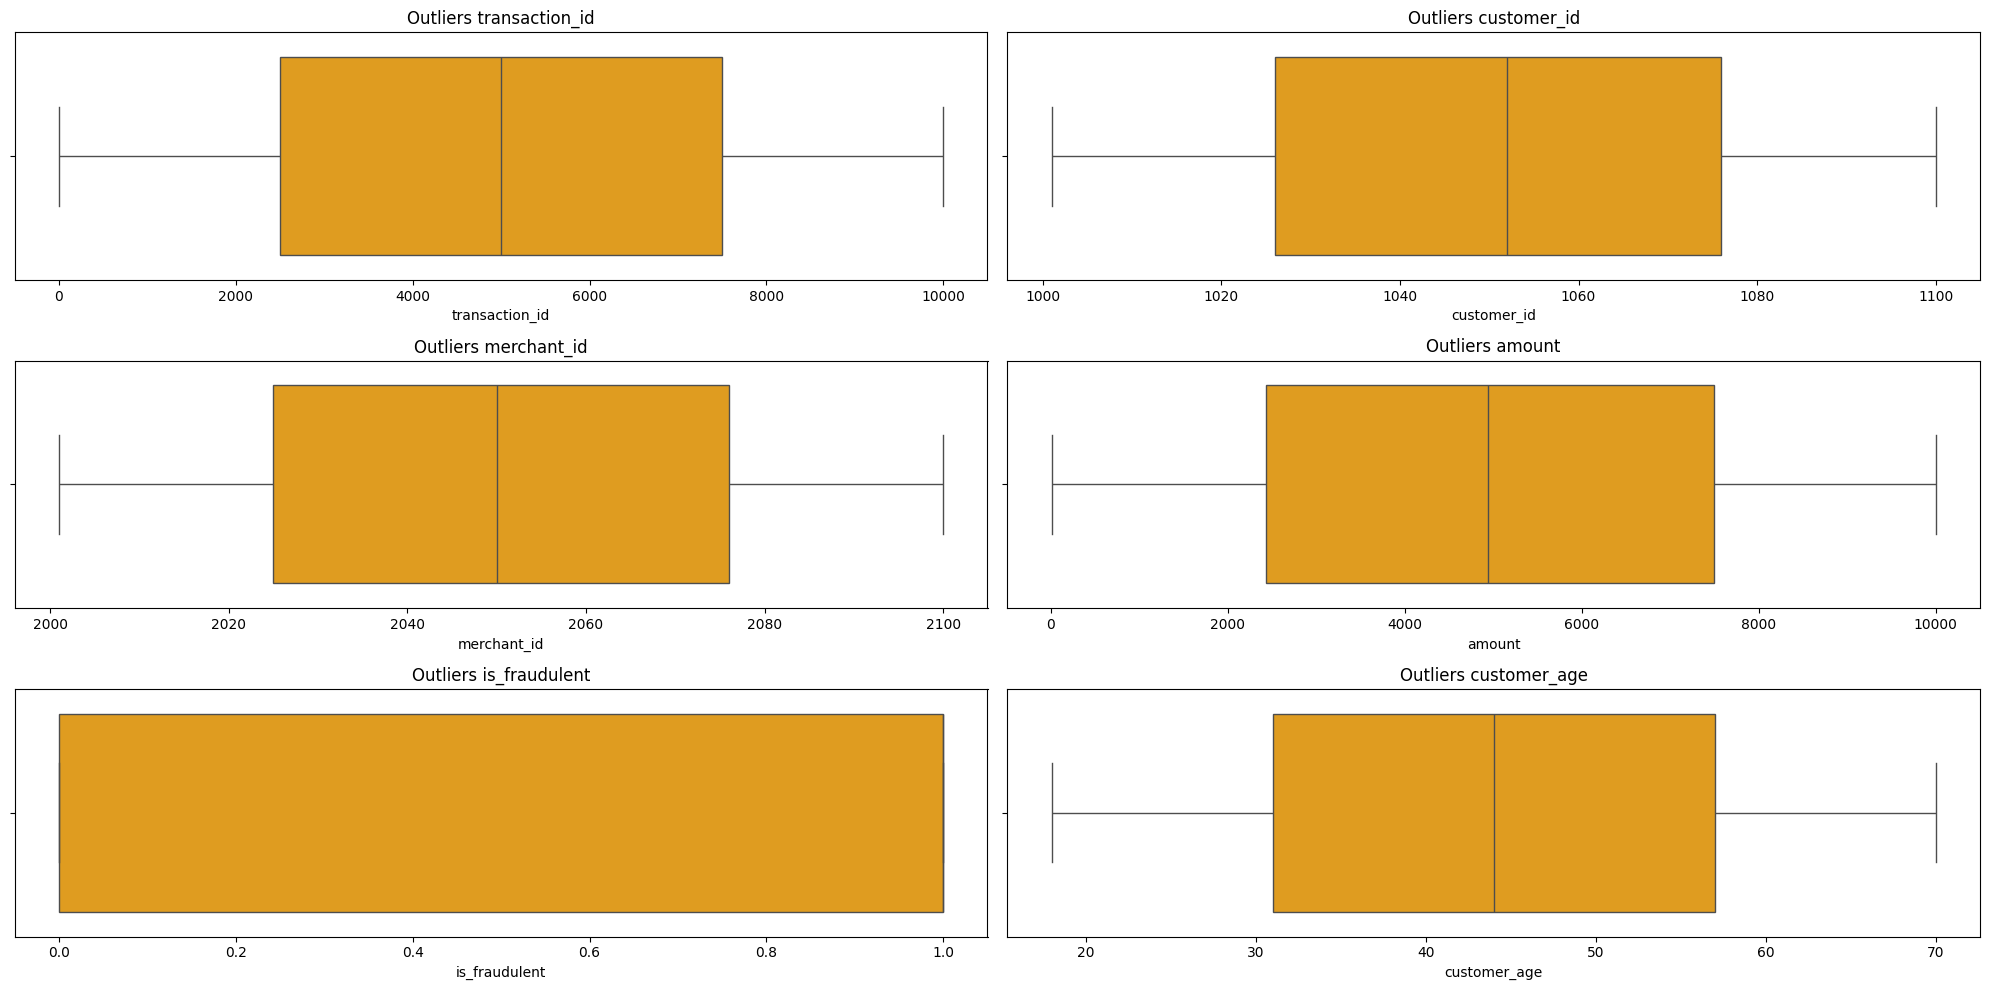

In [292]:
# detectamos los outliers
visualizador.deteccion_outliers(color = "orange")

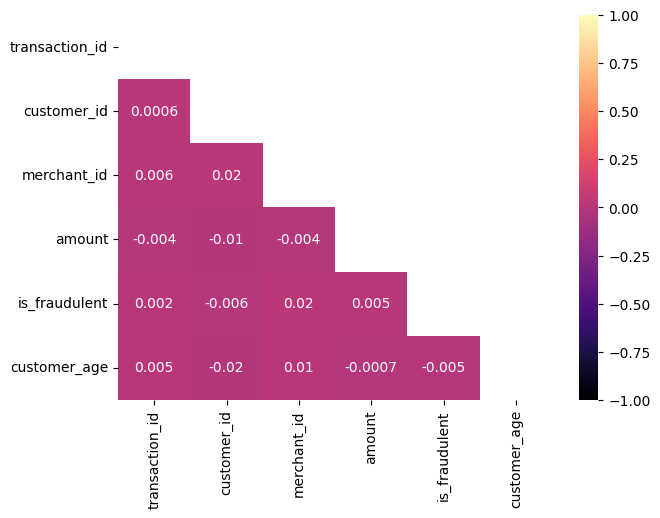

In [293]:
# evaluamos las correlaciones entre las variables numéricas
visualizador.correlacion()

### Conclusiones
- Las relaciones son extremadamentes débiles, cercanas a 0
- Esto sugieres que no hay relaciones fuertes entre ninguna de las variables
- Podemos considerarlas prácticamente independientes unas de otras.

2. **Limpieza de datos:**

   - Identificar y tratar valores nulos.

   - Eliminar duplicados si existen.

   - Asegurar que las variables tienen el tipo de dato correcto.

   - etc. 

# Datos correctos

In [294]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   transaction_id           10000 non-null  int64  
 1   customer_id              10000 non-null  int64  
 2   merchant_id              10000 non-null  int64  
 3   amount                   10000 non-null  float64
 4   transaction_time         10000 non-null  object 
 5   is_fraudulent            10000 non-null  int64  
 6   card_type                10000 non-null  object 
 7   location                 10000 non-null  object 
 8   purchase_category        10000 non-null  object 
 9   customer_age             10000 non-null  int64  
 10  transaction_description  10000 non-null  object 
dtypes: float64(1), int64(5), object(5)
memory usage: 859.5+ KB


Parecen correctos

# Eliminar columnas
- transaction_time: No aporta valor 
- transaction_description: No aporta valor
- transaction_id: no nos interesa y solo da ruido

In [295]:
cols_chao = ["transaction_time","transaction_description","transaction_id","location"]
df.drop(columns=cols_chao,inplace=True)

# Nulos

In [296]:
df.isnull().sum()

customer_id          0
merchant_id          0
amount               0
is_fraudulent        0
card_type            0
purchase_category    0
customer_age         0
dtype: int64

No hay nulos

# Duplicados

In [297]:
df.duplicated().sum()

np.int64(0)

No hay duplicados

# Outliers

### Multivariados

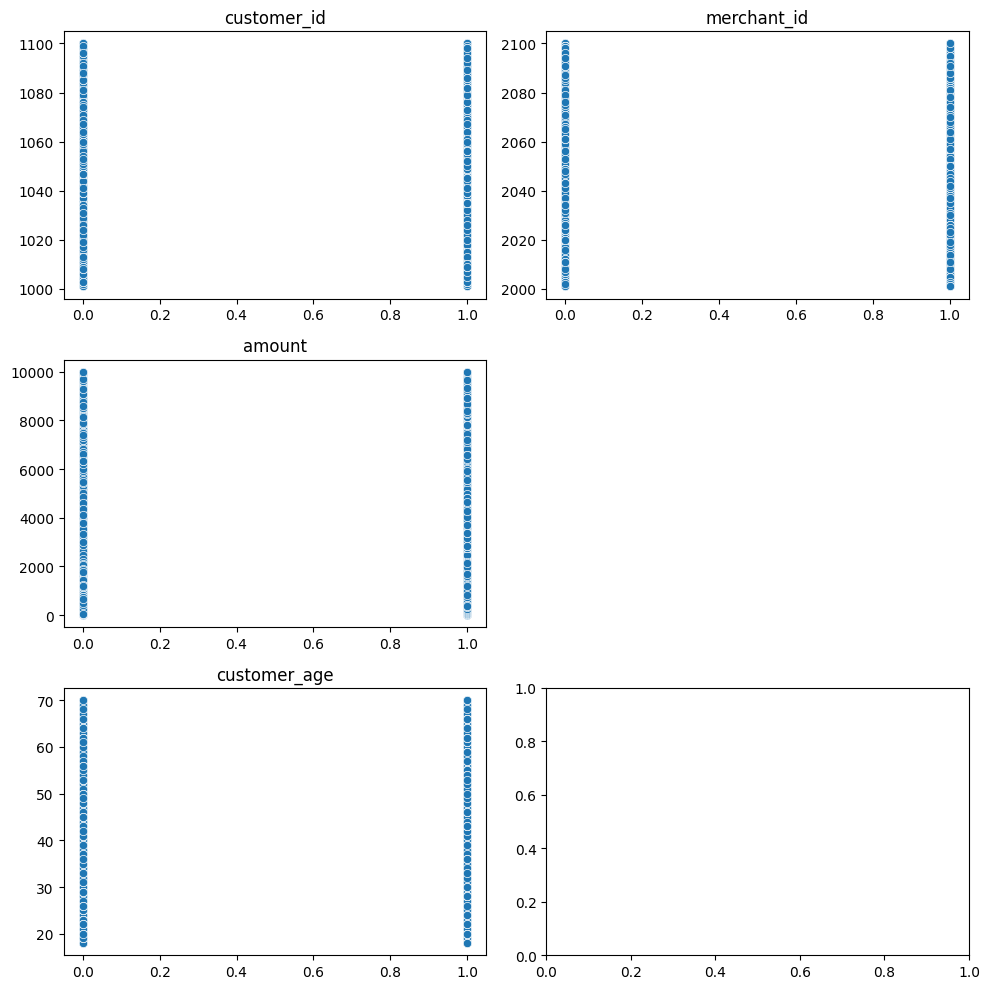

In [298]:
visualizar_outliers_bivariados(df,"is_fraudulent",(10,10))

# Local Outlier Forest


se ha hecho outlier_0.01_customer_id_lof
se ha hecho outlier_0.01_merchant_id_lof
se ha hecho outlier_0.01_amount_lof
se ha hecho outlier_0.01_customer_age_lof


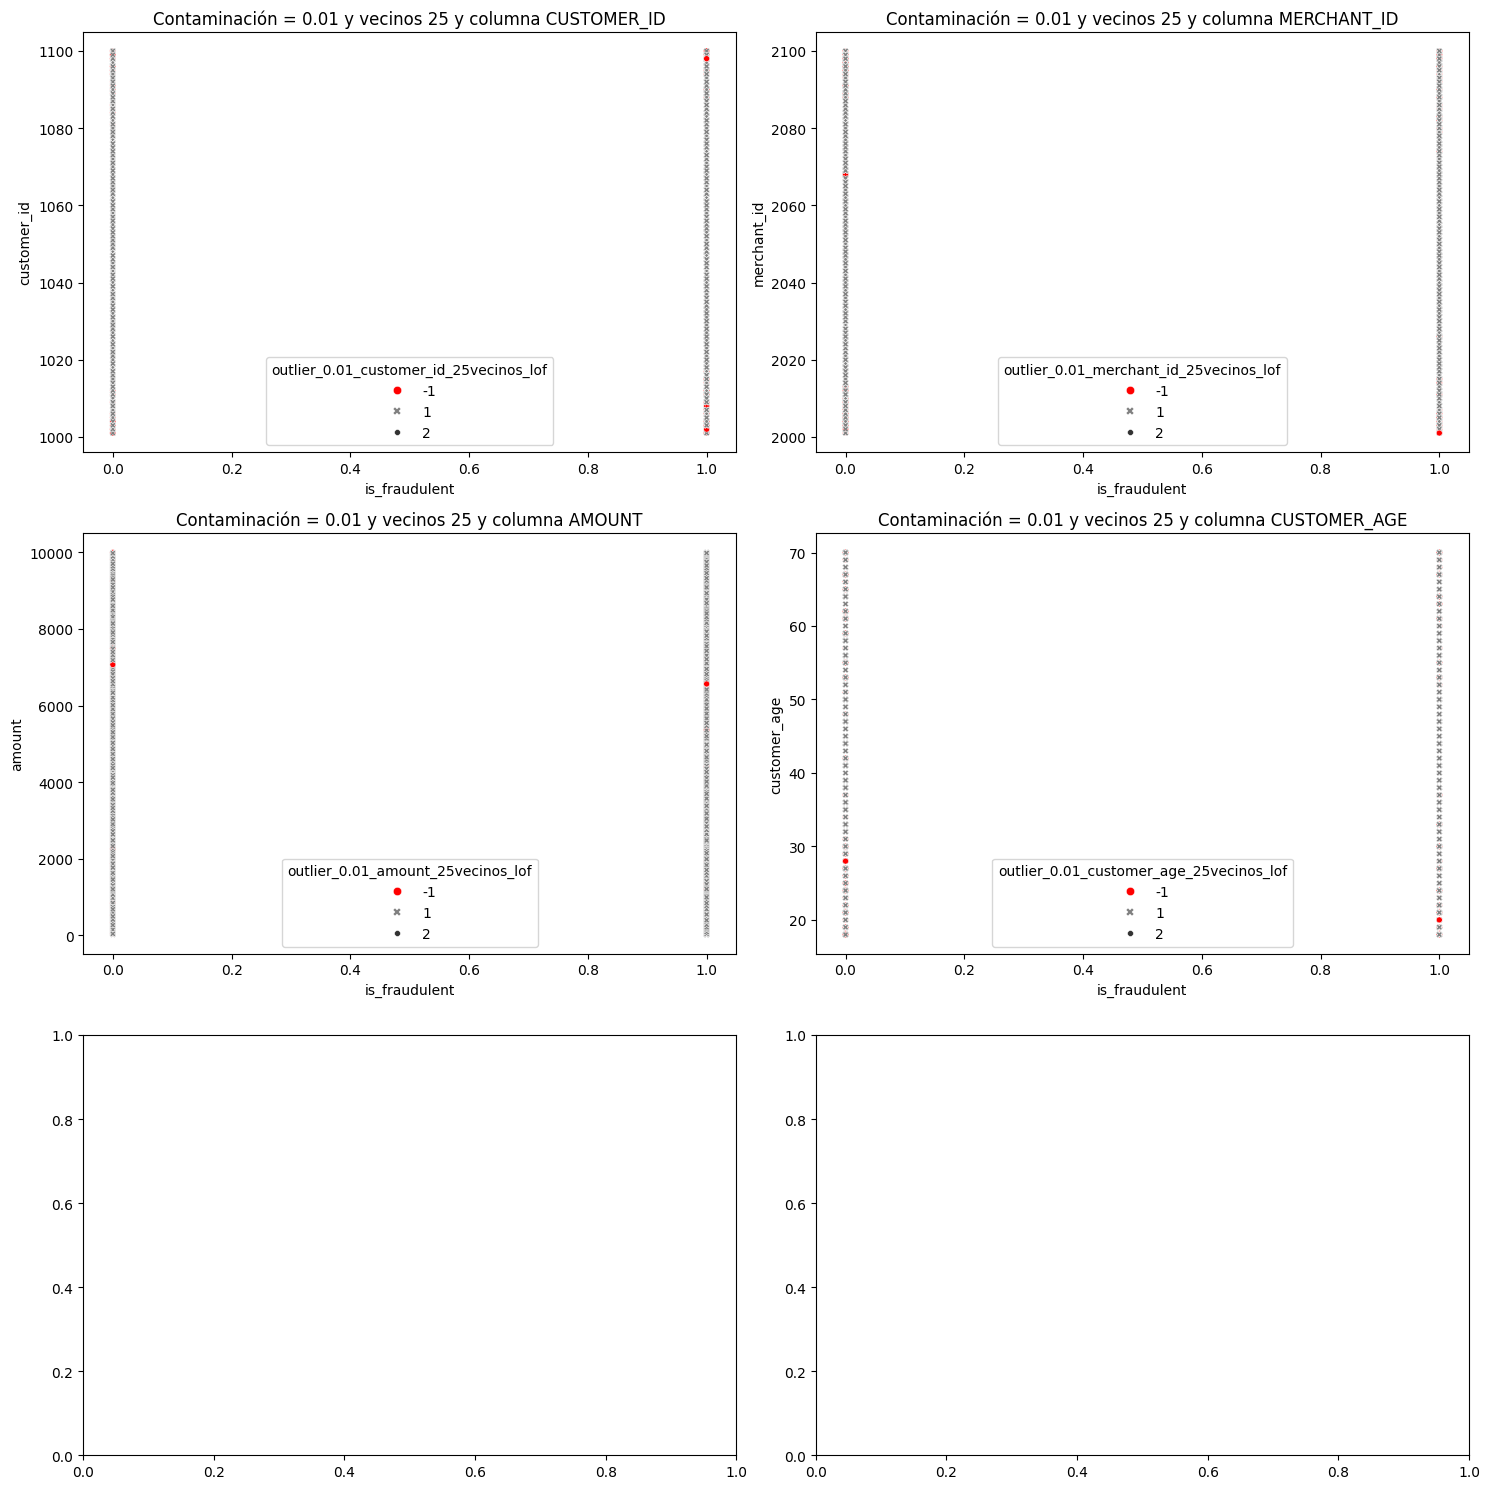

se ha hecho outlier_0.05_customer_id_lof
se ha hecho outlier_0.05_merchant_id_lof
se ha hecho outlier_0.05_amount_lof
se ha hecho outlier_0.05_customer_age_lof


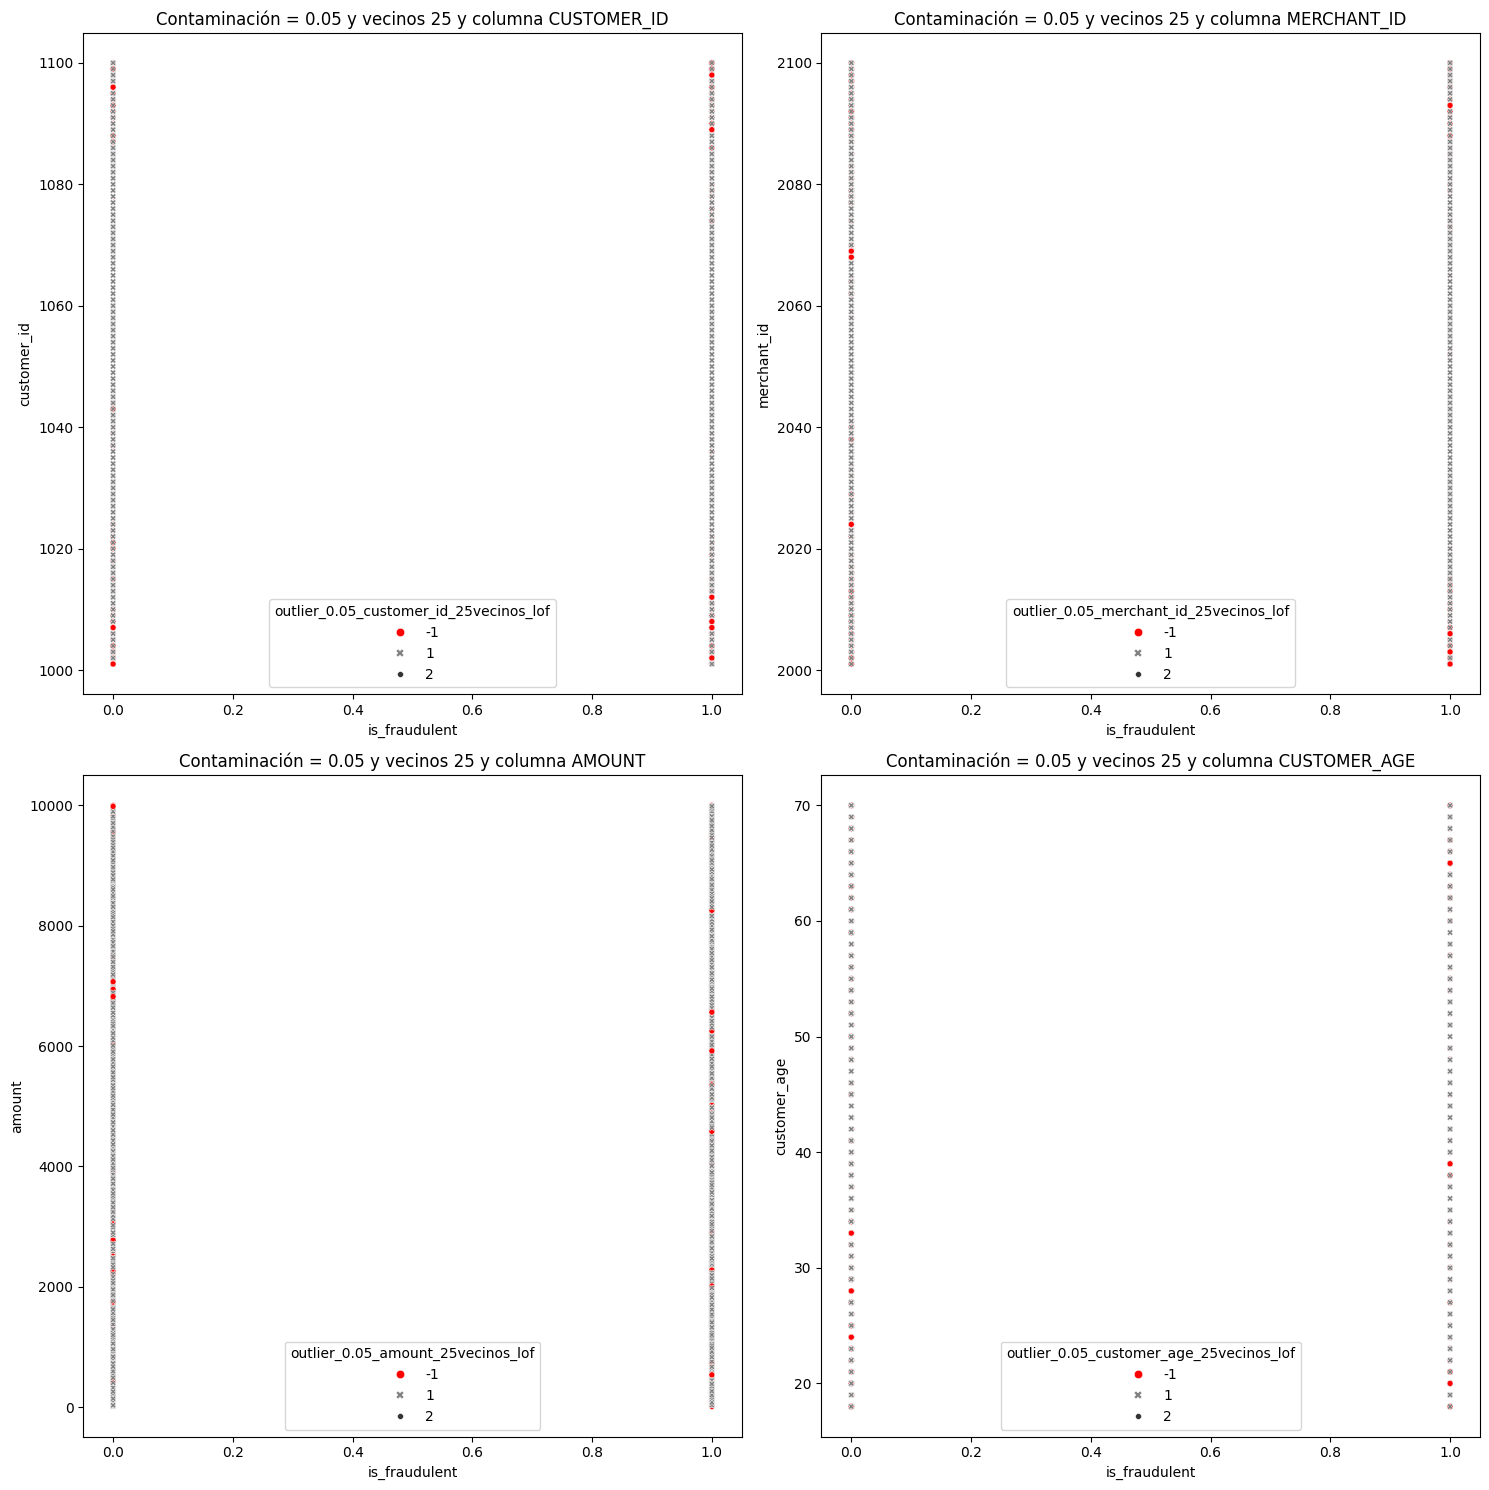

se ha hecho outlier_0.1_customer_id_lof
se ha hecho outlier_0.1_merchant_id_lof
se ha hecho outlier_0.1_amount_lof
se ha hecho outlier_0.1_customer_age_lof


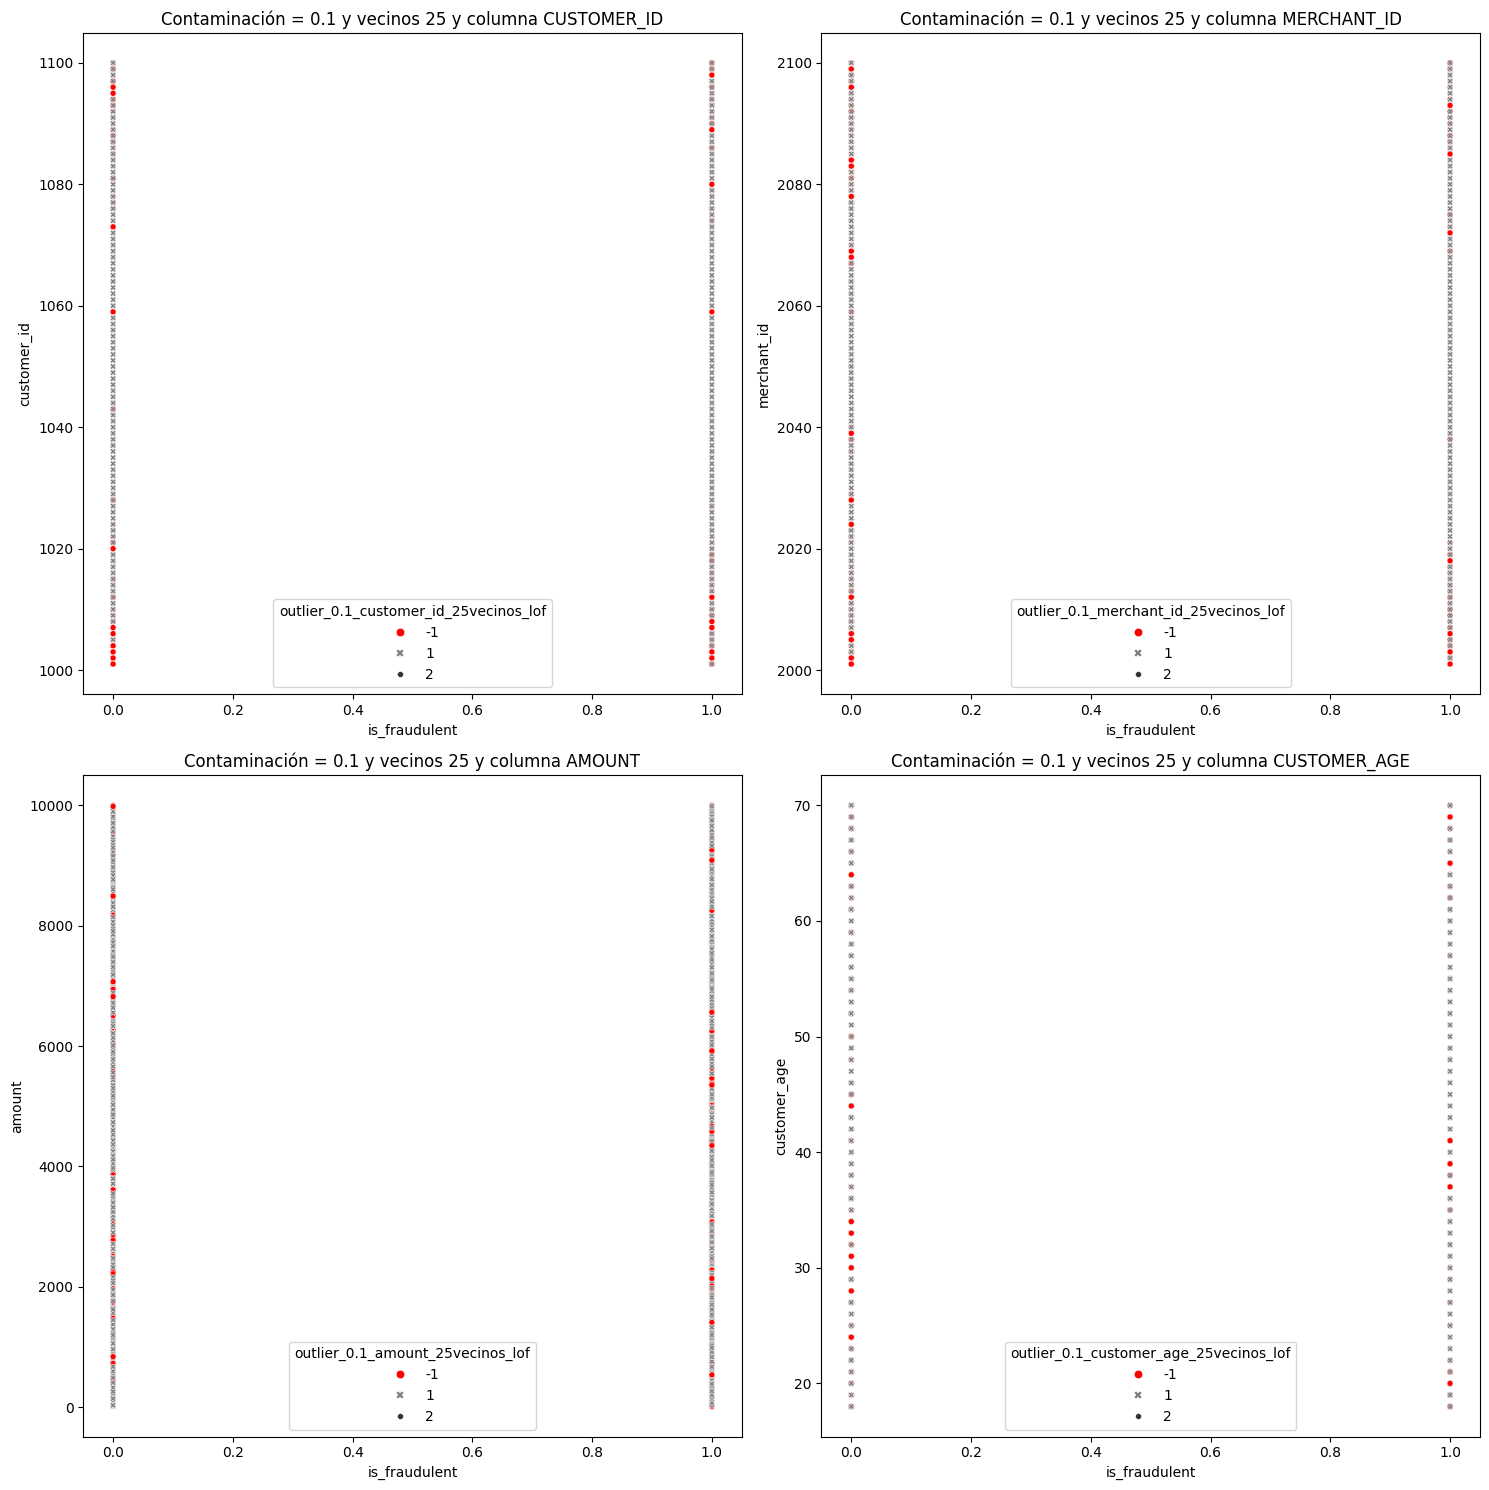

se ha hecho outlier_0.01_customer_id_lof
se ha hecho outlier_0.01_merchant_id_lof
se ha hecho outlier_0.01_amount_lof
se ha hecho outlier_0.01_customer_age_lof


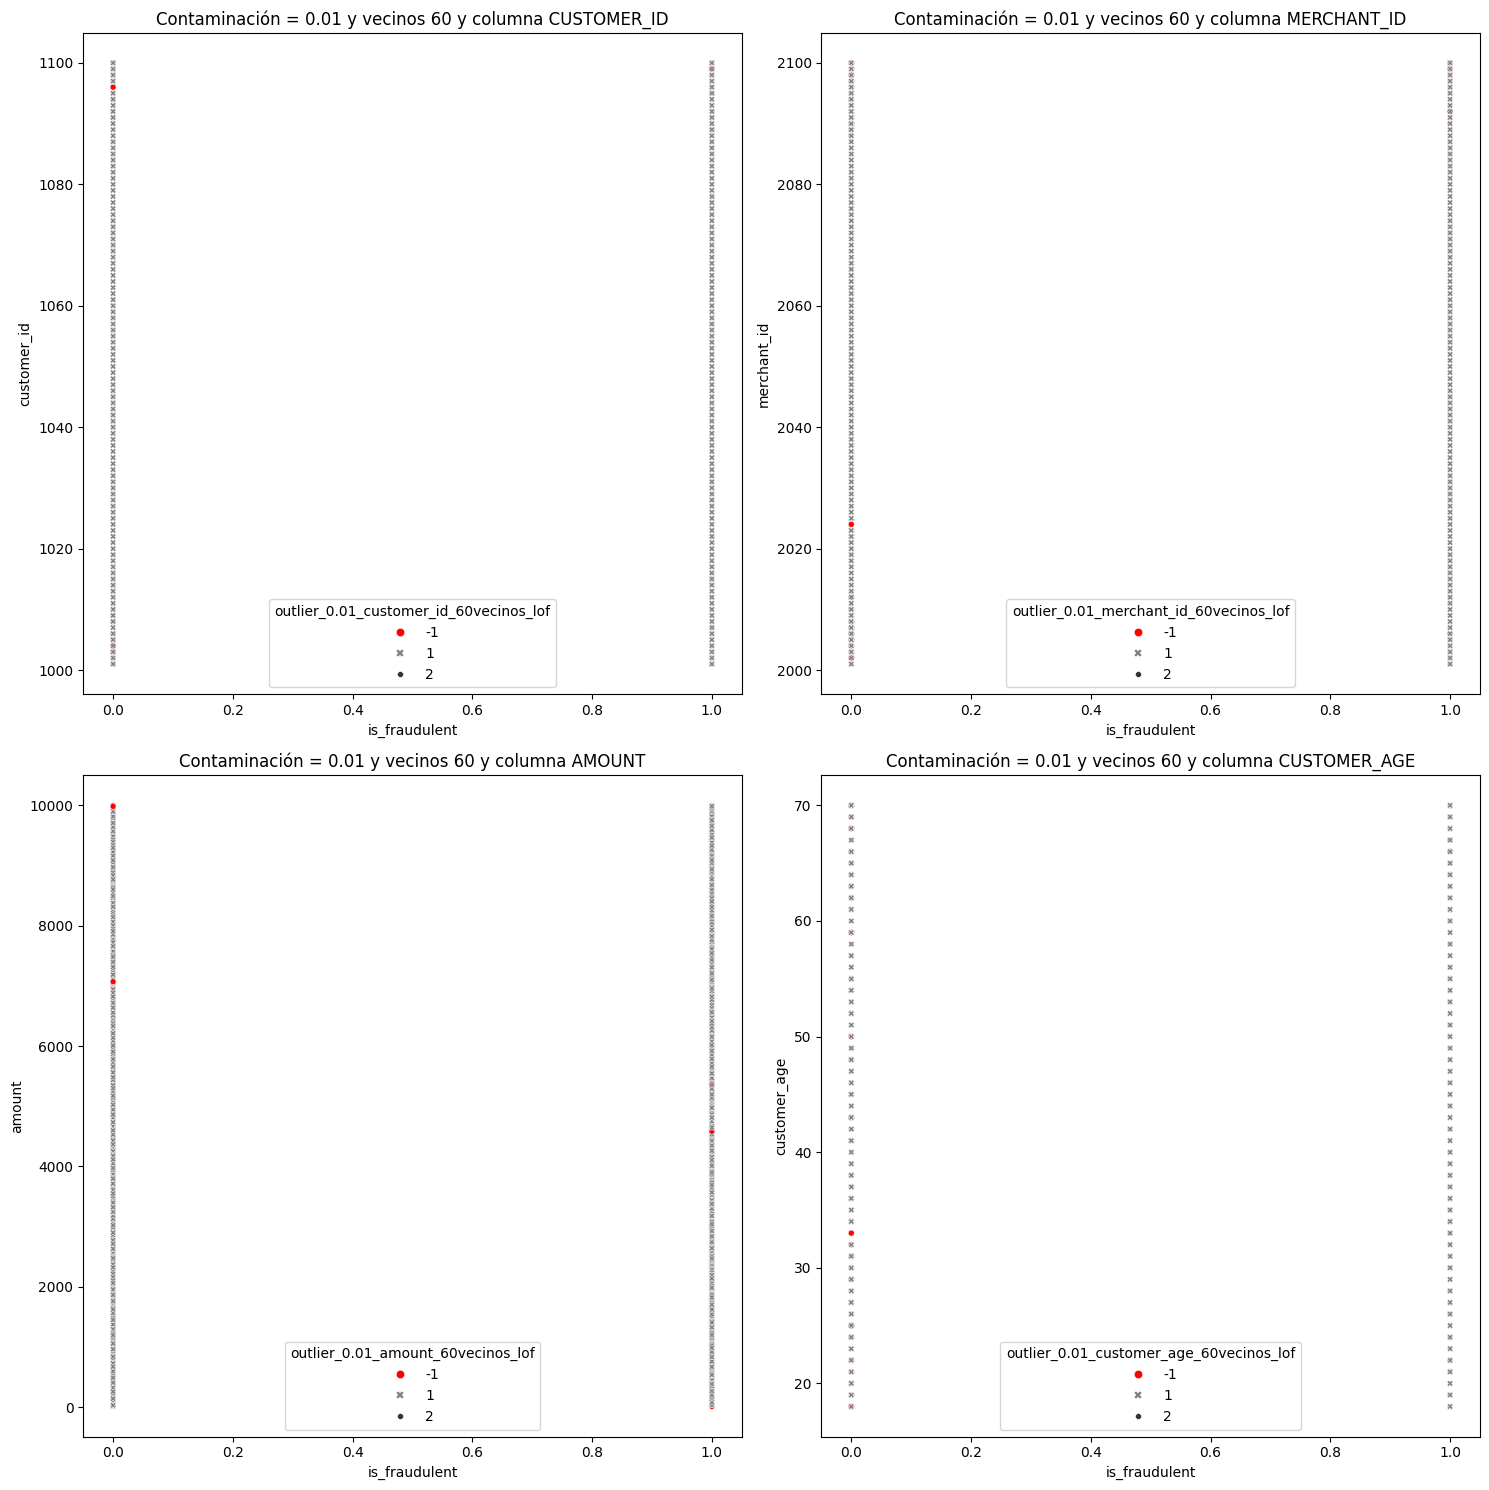

se ha hecho outlier_0.05_customer_id_lof
se ha hecho outlier_0.05_merchant_id_lof
se ha hecho outlier_0.05_amount_lof
se ha hecho outlier_0.05_customer_age_lof


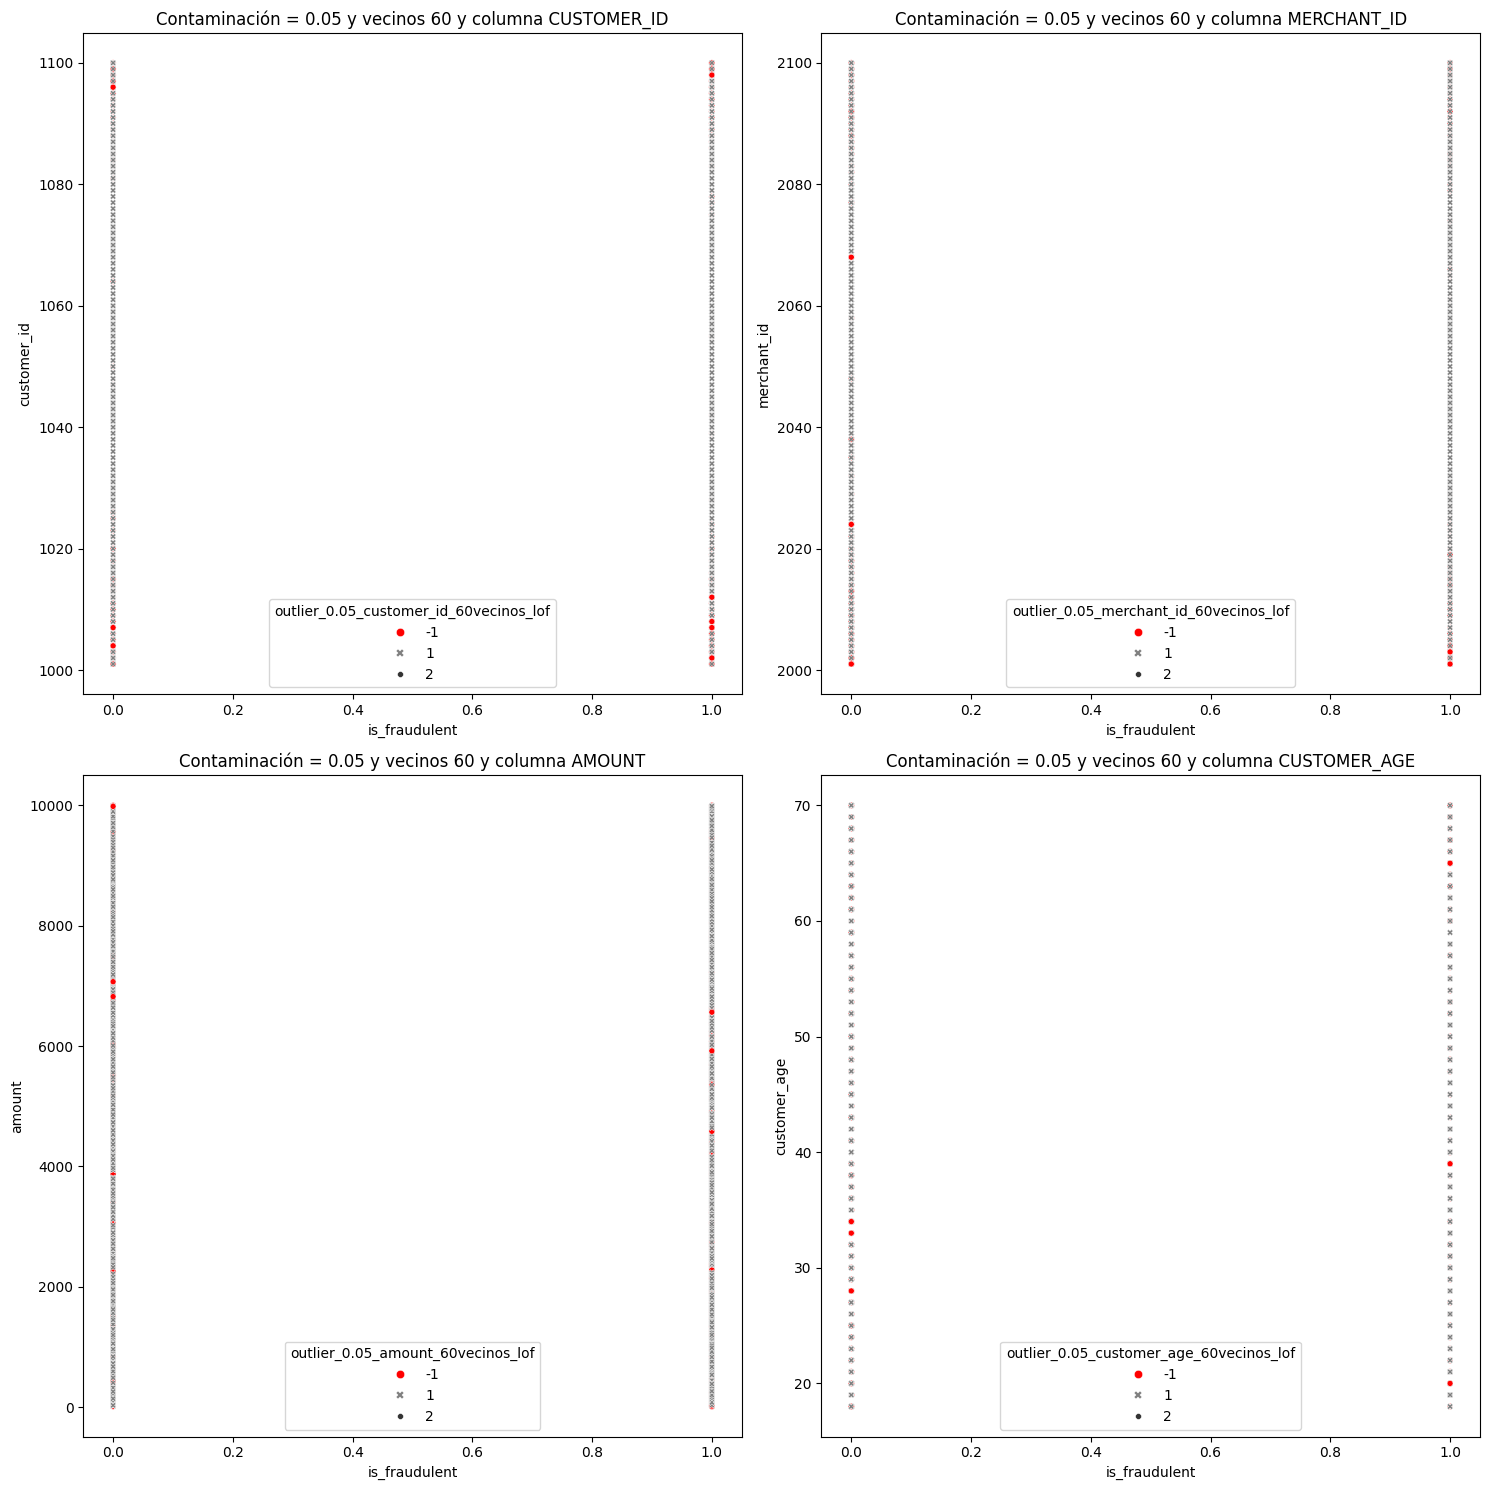

se ha hecho outlier_0.1_customer_id_lof
se ha hecho outlier_0.1_merchant_id_lof
se ha hecho outlier_0.1_amount_lof
se ha hecho outlier_0.1_customer_age_lof


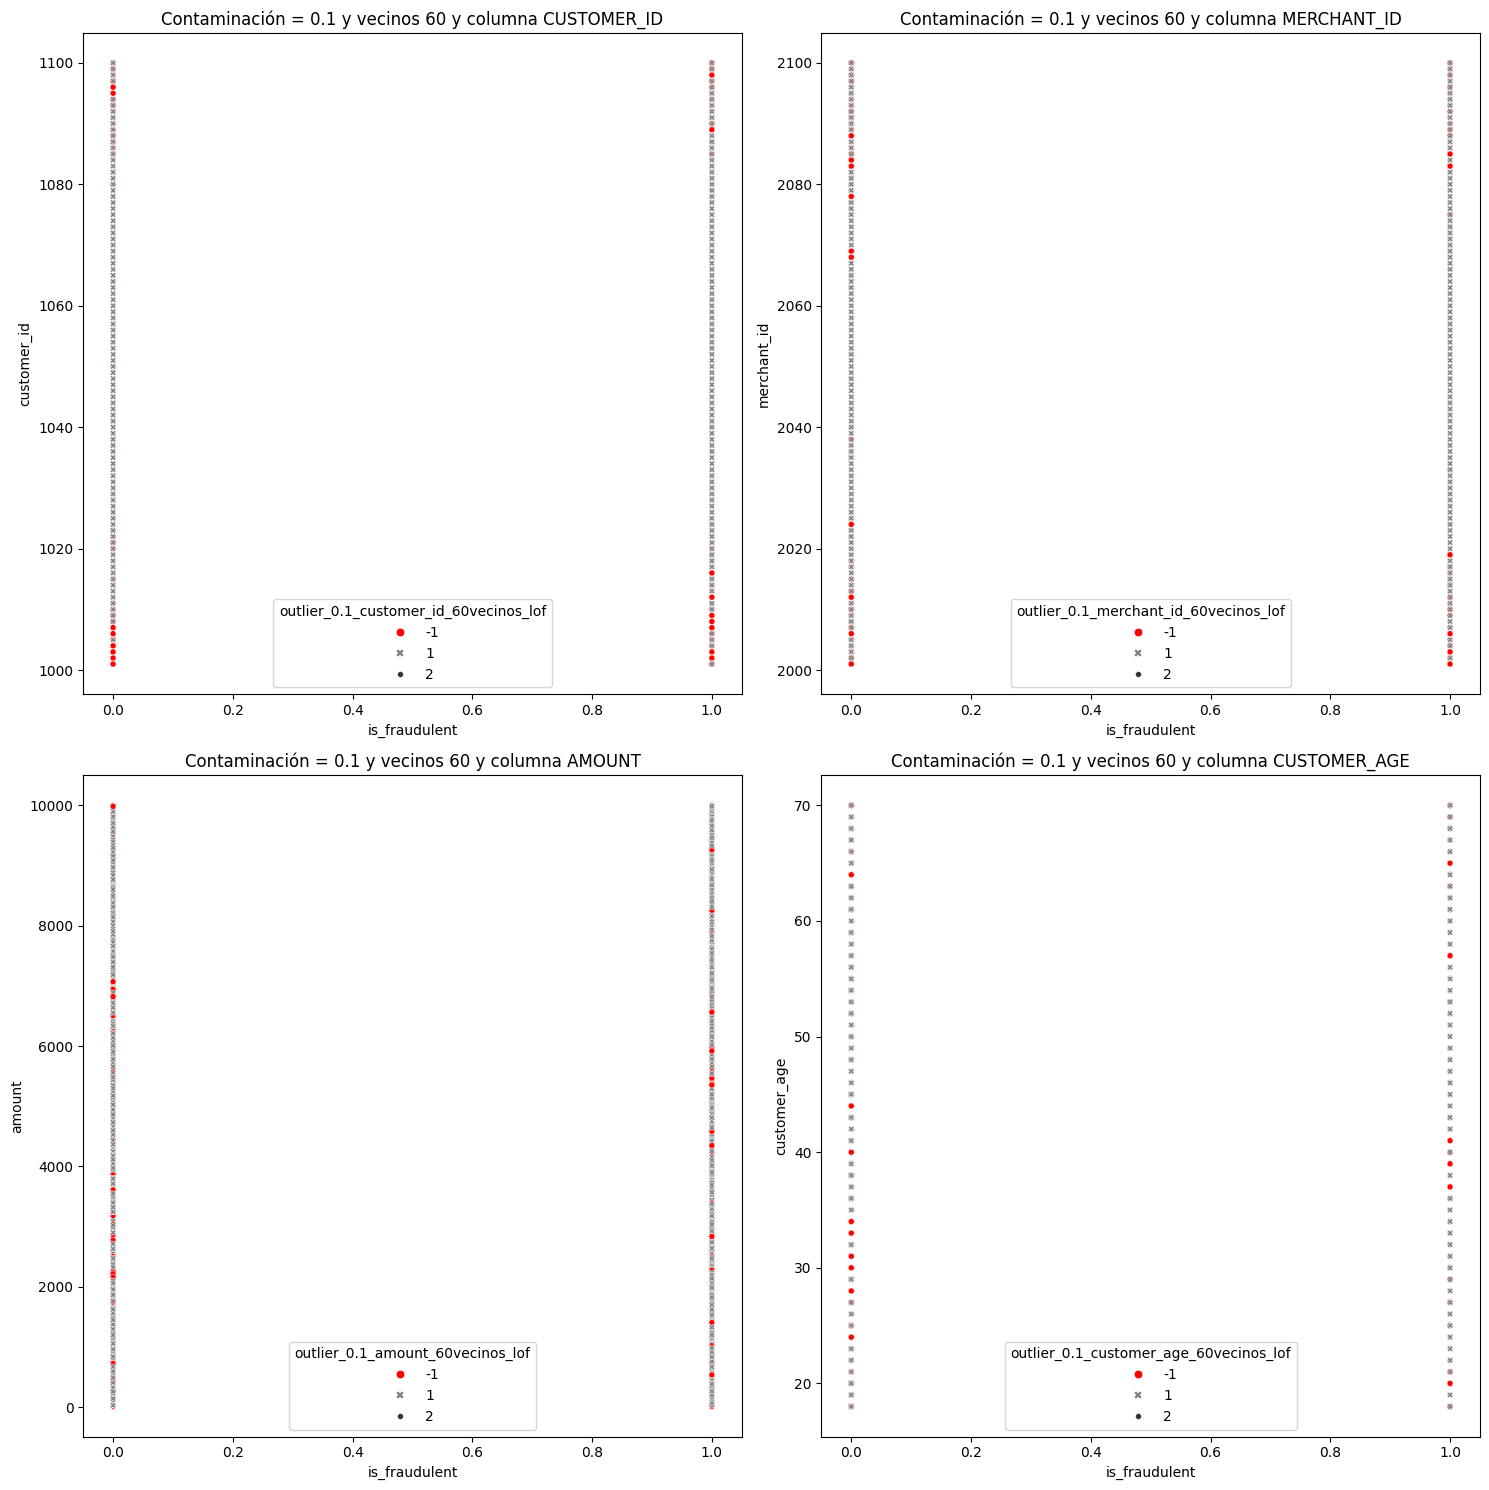

se ha hecho outlier_0.01_customer_id_lof
se ha hecho outlier_0.01_merchant_id_lof
se ha hecho outlier_0.01_amount_lof
se ha hecho outlier_0.01_customer_age_lof


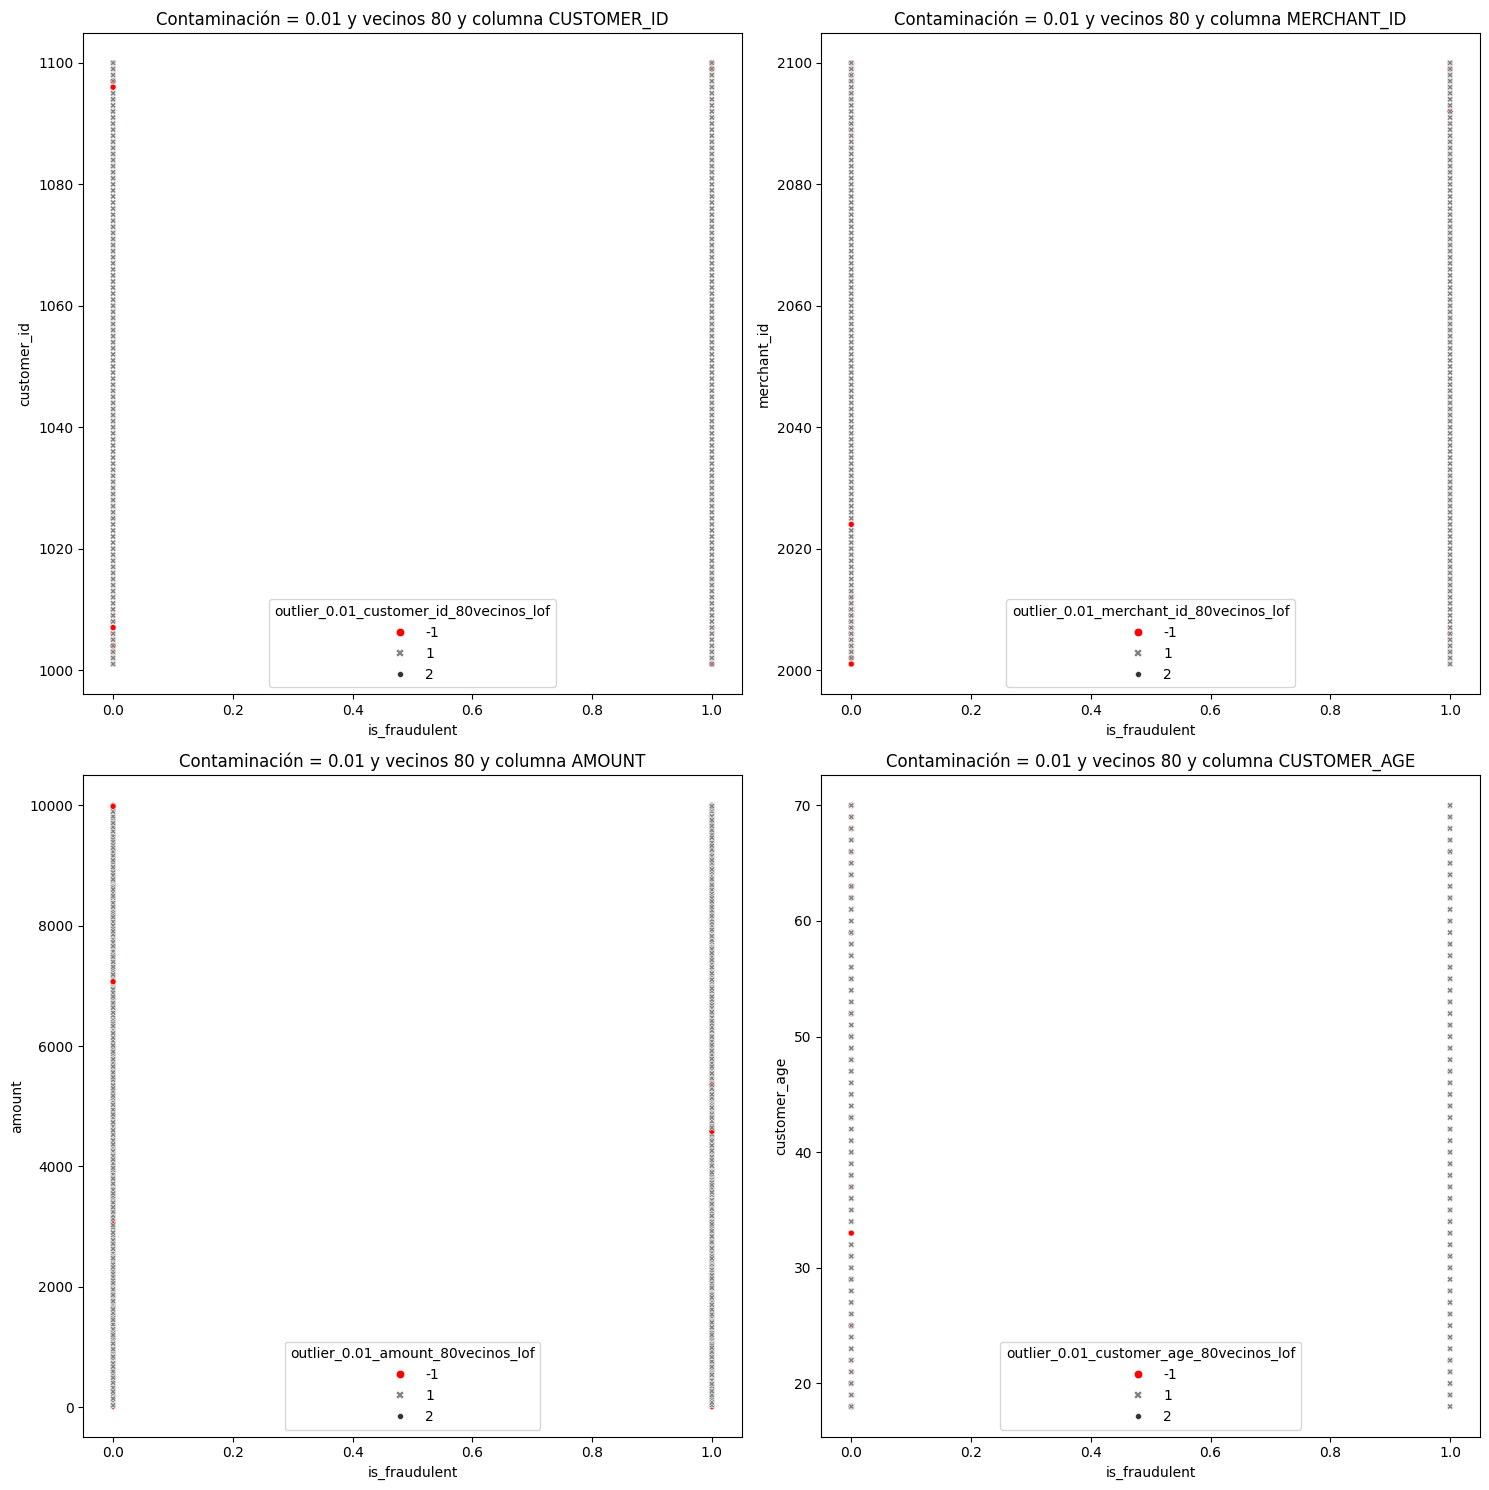

se ha hecho outlier_0.05_customer_id_lof
se ha hecho outlier_0.05_merchant_id_lof
se ha hecho outlier_0.05_amount_lof
se ha hecho outlier_0.05_customer_age_lof


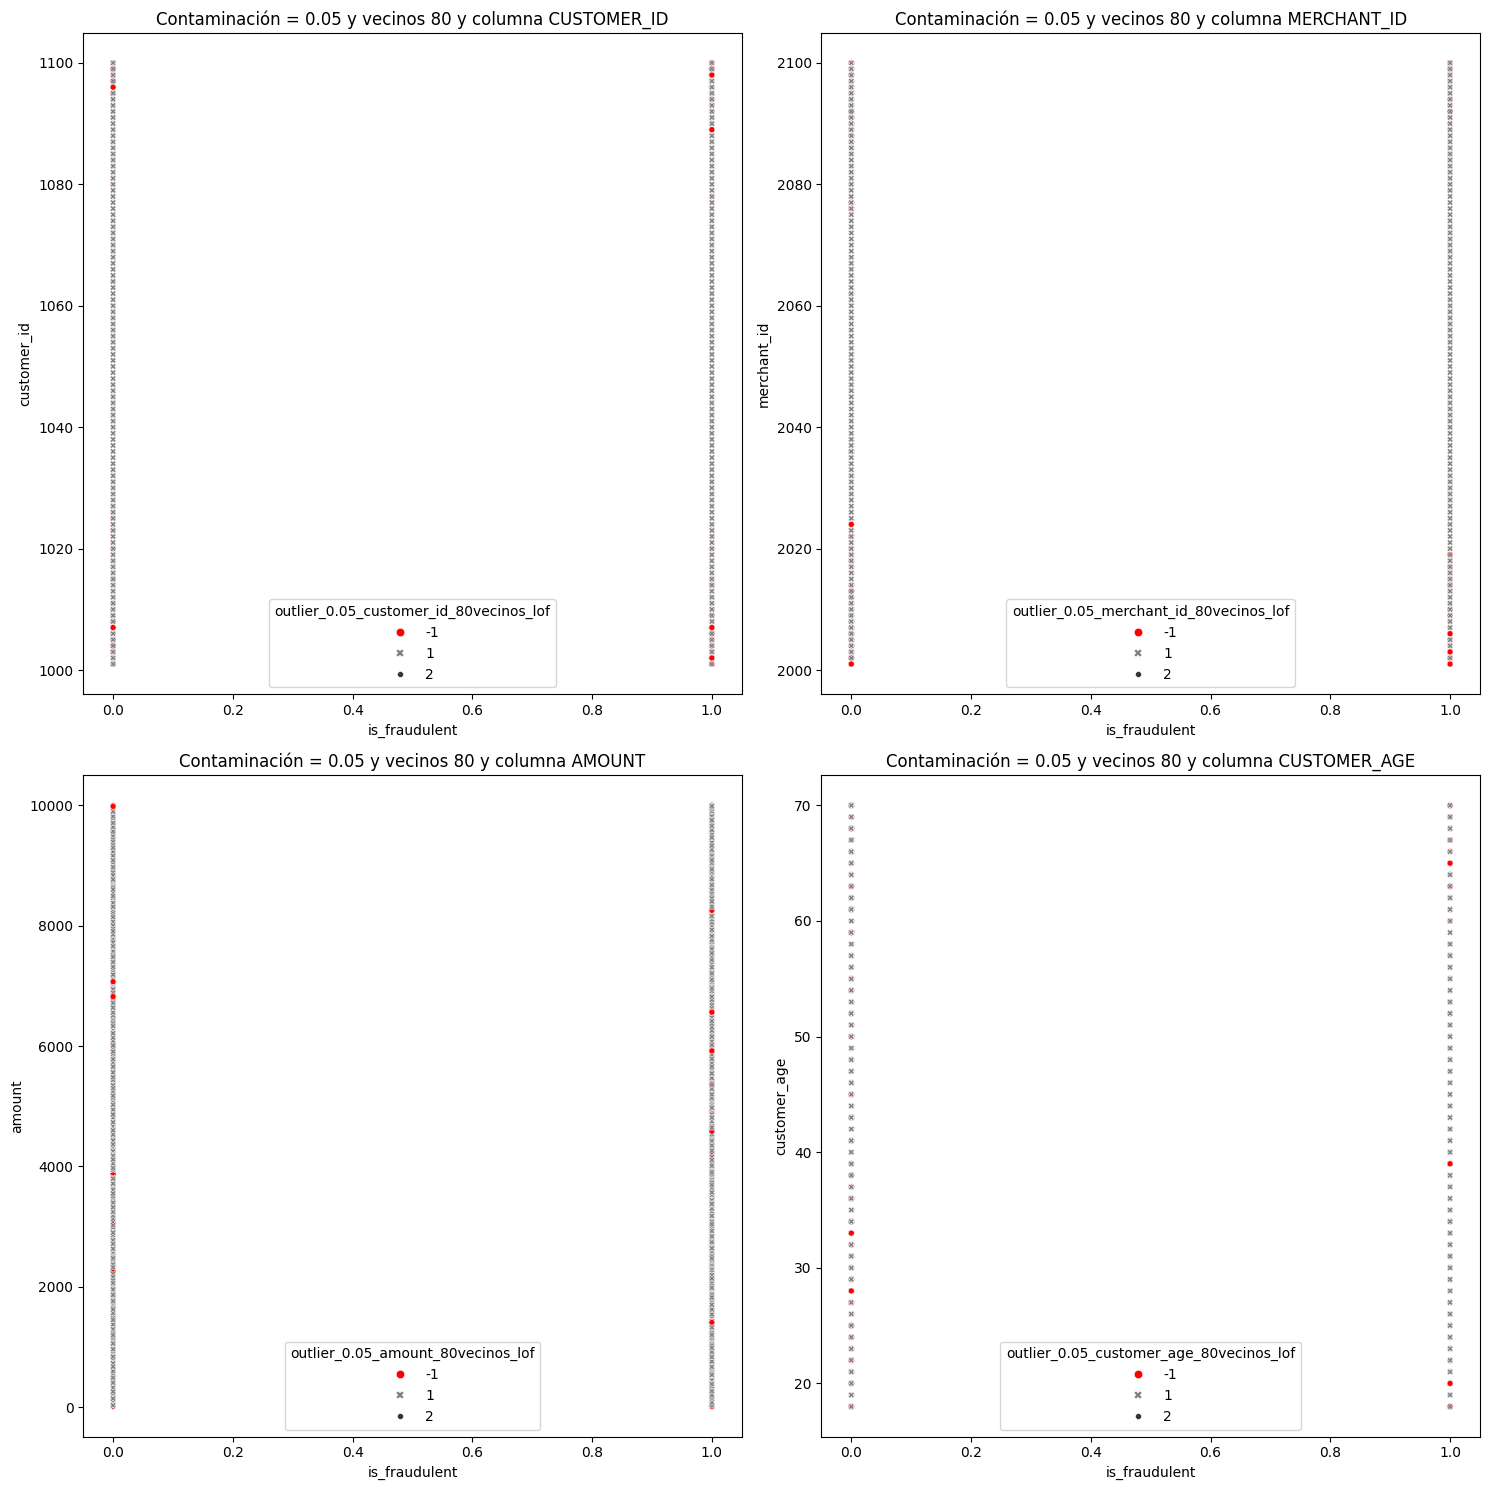

se ha hecho outlier_0.1_customer_id_lof
se ha hecho outlier_0.1_merchant_id_lof
se ha hecho outlier_0.1_amount_lof
se ha hecho outlier_0.1_customer_age_lof


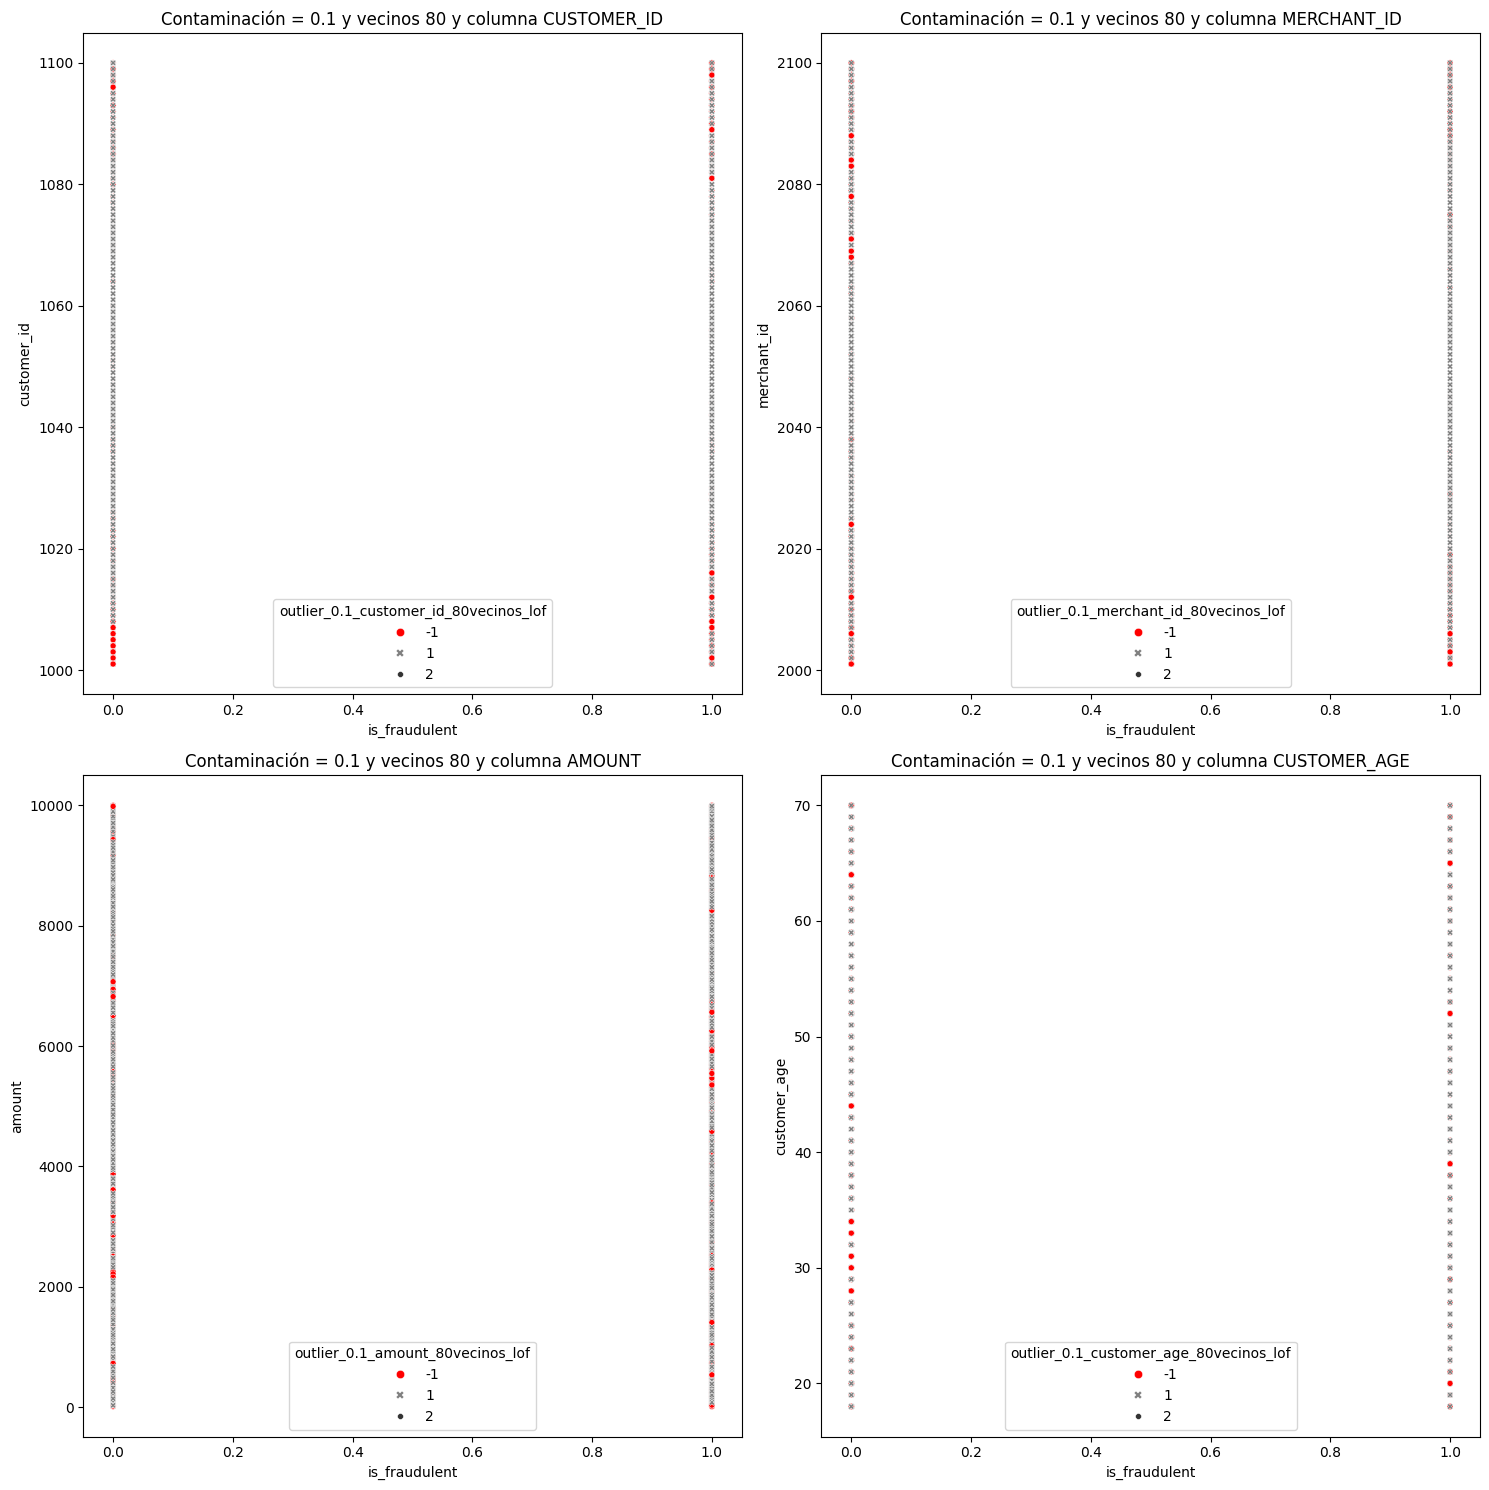

Se devuelve df Modificado


In [299]:
df_lof = explorar_outliers_lof(df,df,"is_fraudulent",vecinos=[25,60,80],grafica_size=(15,15))

In [300]:
df_lof.sample()

,customer_id,merchant_id,amount,is_fraudulent,card_type,purchase_category,customer_age,outlier_0.01_customer_id_25vecinos_lof,outlier_0.01_merchant_id_25vecinos_lof,outlier_0.01_amount_25vecinos_lof,...,outlier_0.01_amount_80vecinos_lof,outlier_0.01_customer_age_80vecinos_lof,outlier_0.05_customer_id_80vecinos_lof,outlier_0.05_merchant_id_80vecinos_lof,outlier_0.05_amount_80vecinos_lof,outlier_0.05_customer_age_80vecinos_lof,outlier_0.1_customer_id_80vecinos_lof,outlier_0.1_merchant_id_80vecinos_lof,outlier_0.1_amount_80vecinos_lof,outlier_0.1_customer_age_80vecinos_lof
6573,1041,2099,7913.73,0,MasterCard,Retail,57,1,1,1,...,1,1,1,1,1,1,1,1,1,1


# Isolation Forest

se ha hecho outlier_0.01_customer_age_isoforest
se ha hecho outlier_0.05_customer_age_isoforest
se ha hecho outlier_0.1_customer_age_isoforest
Se devuelve df Modificado


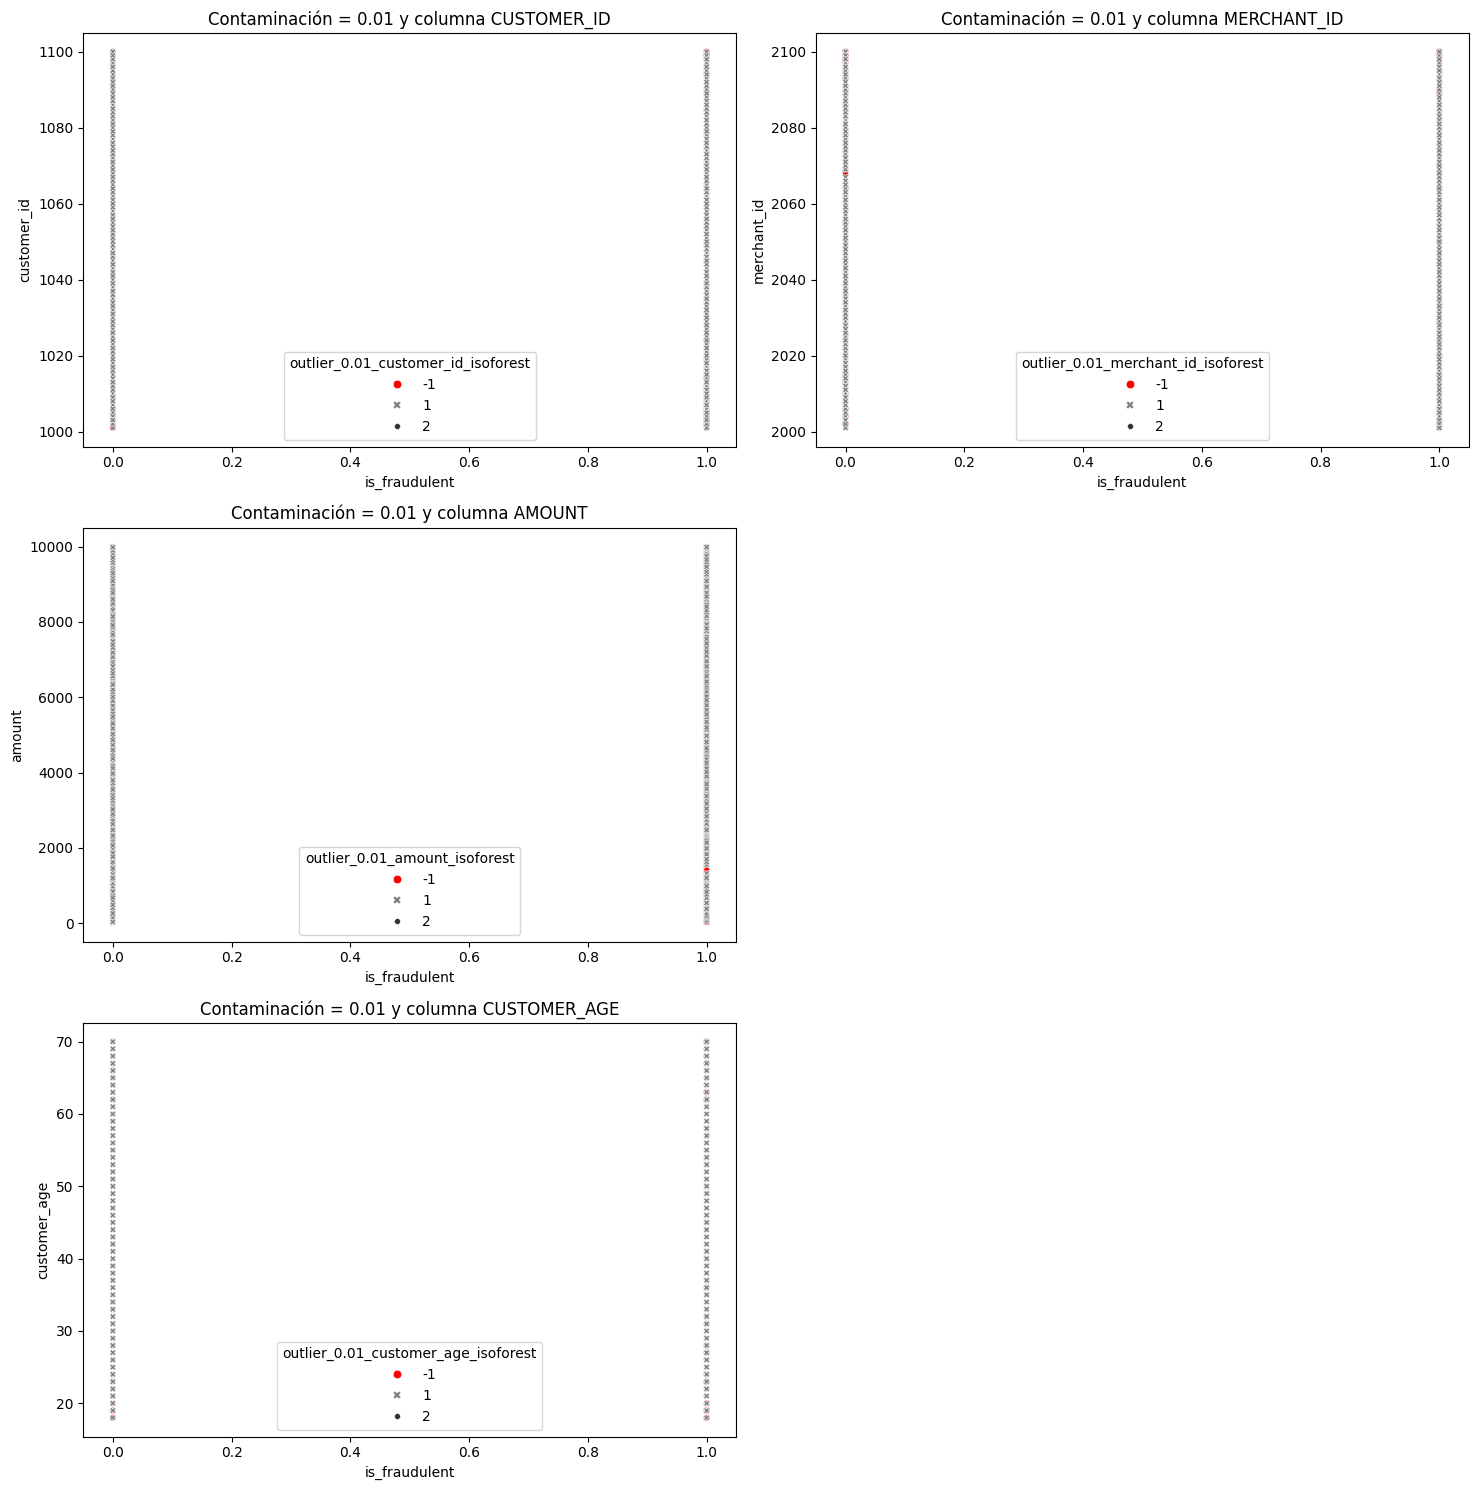

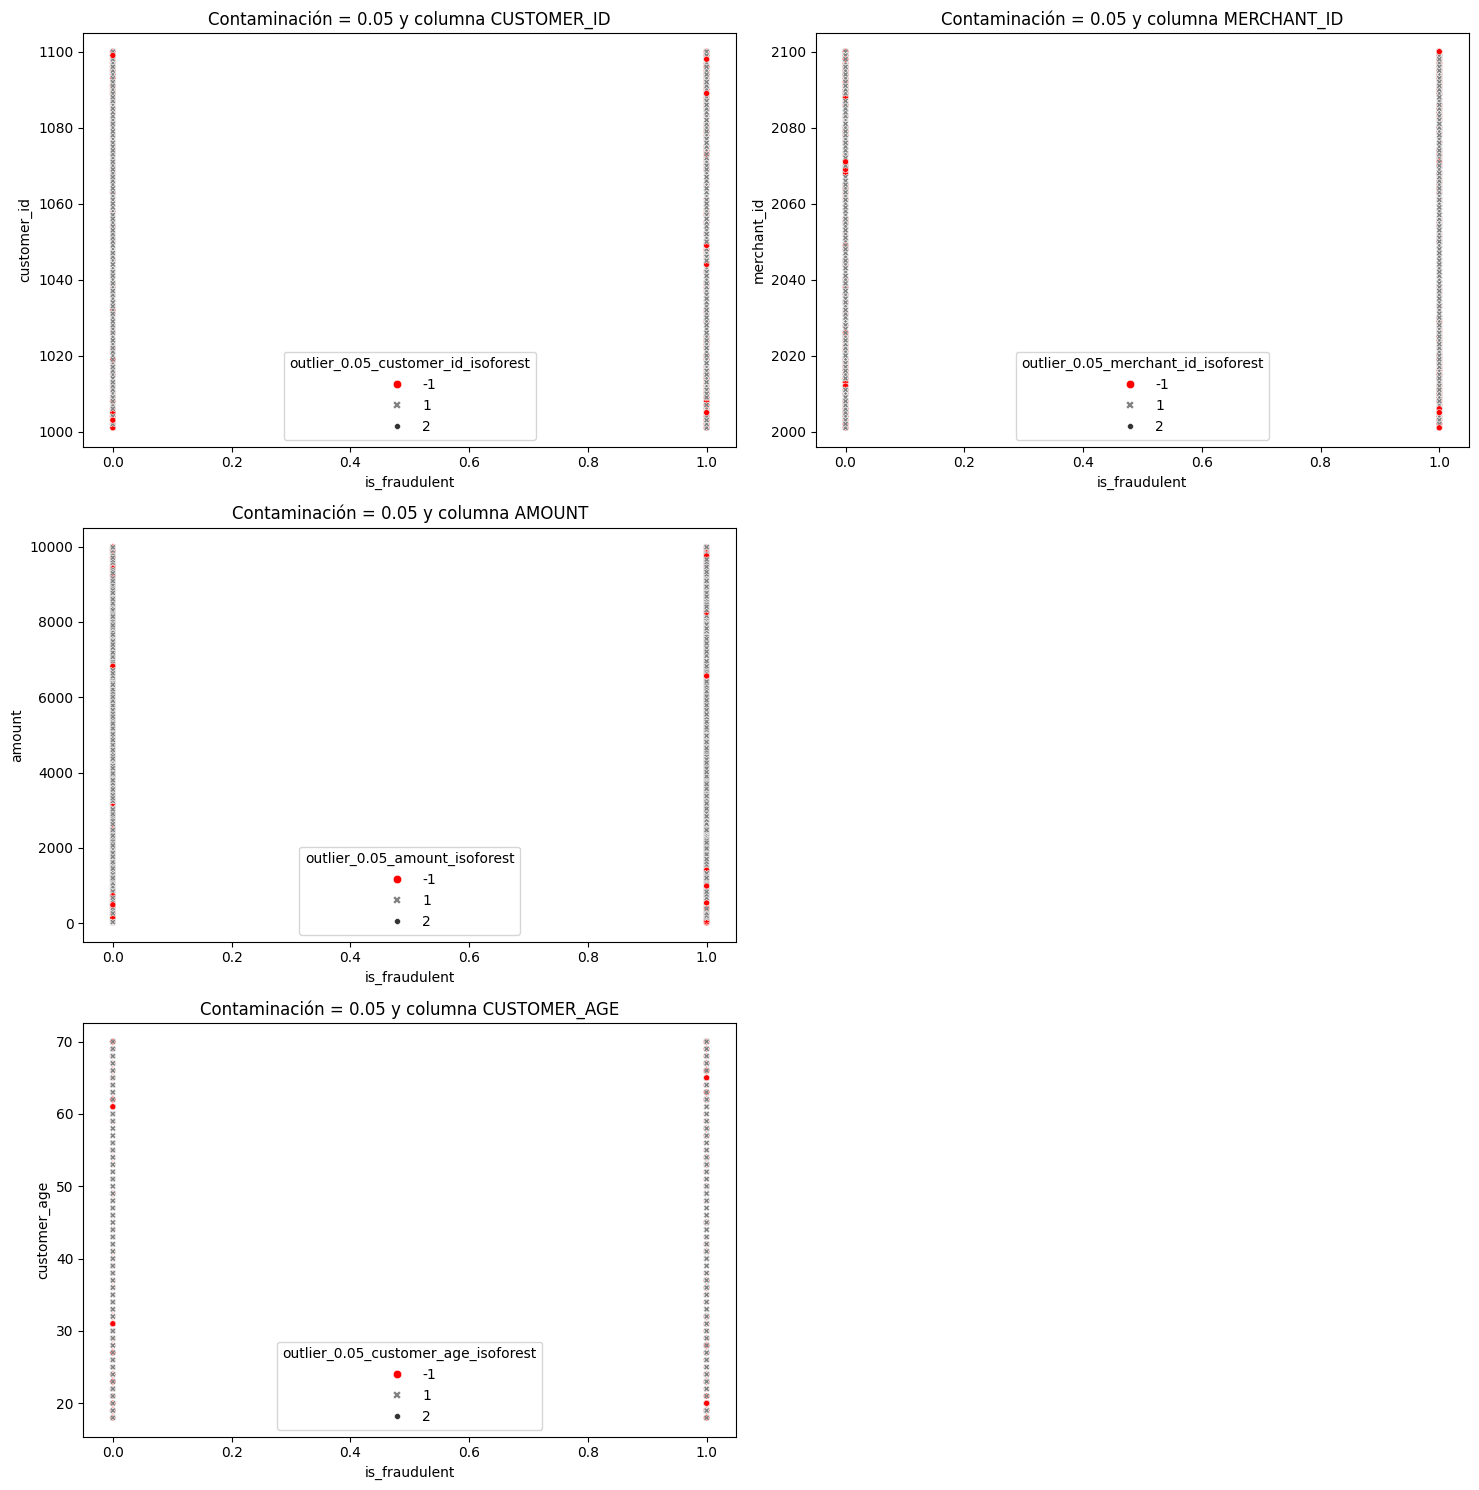

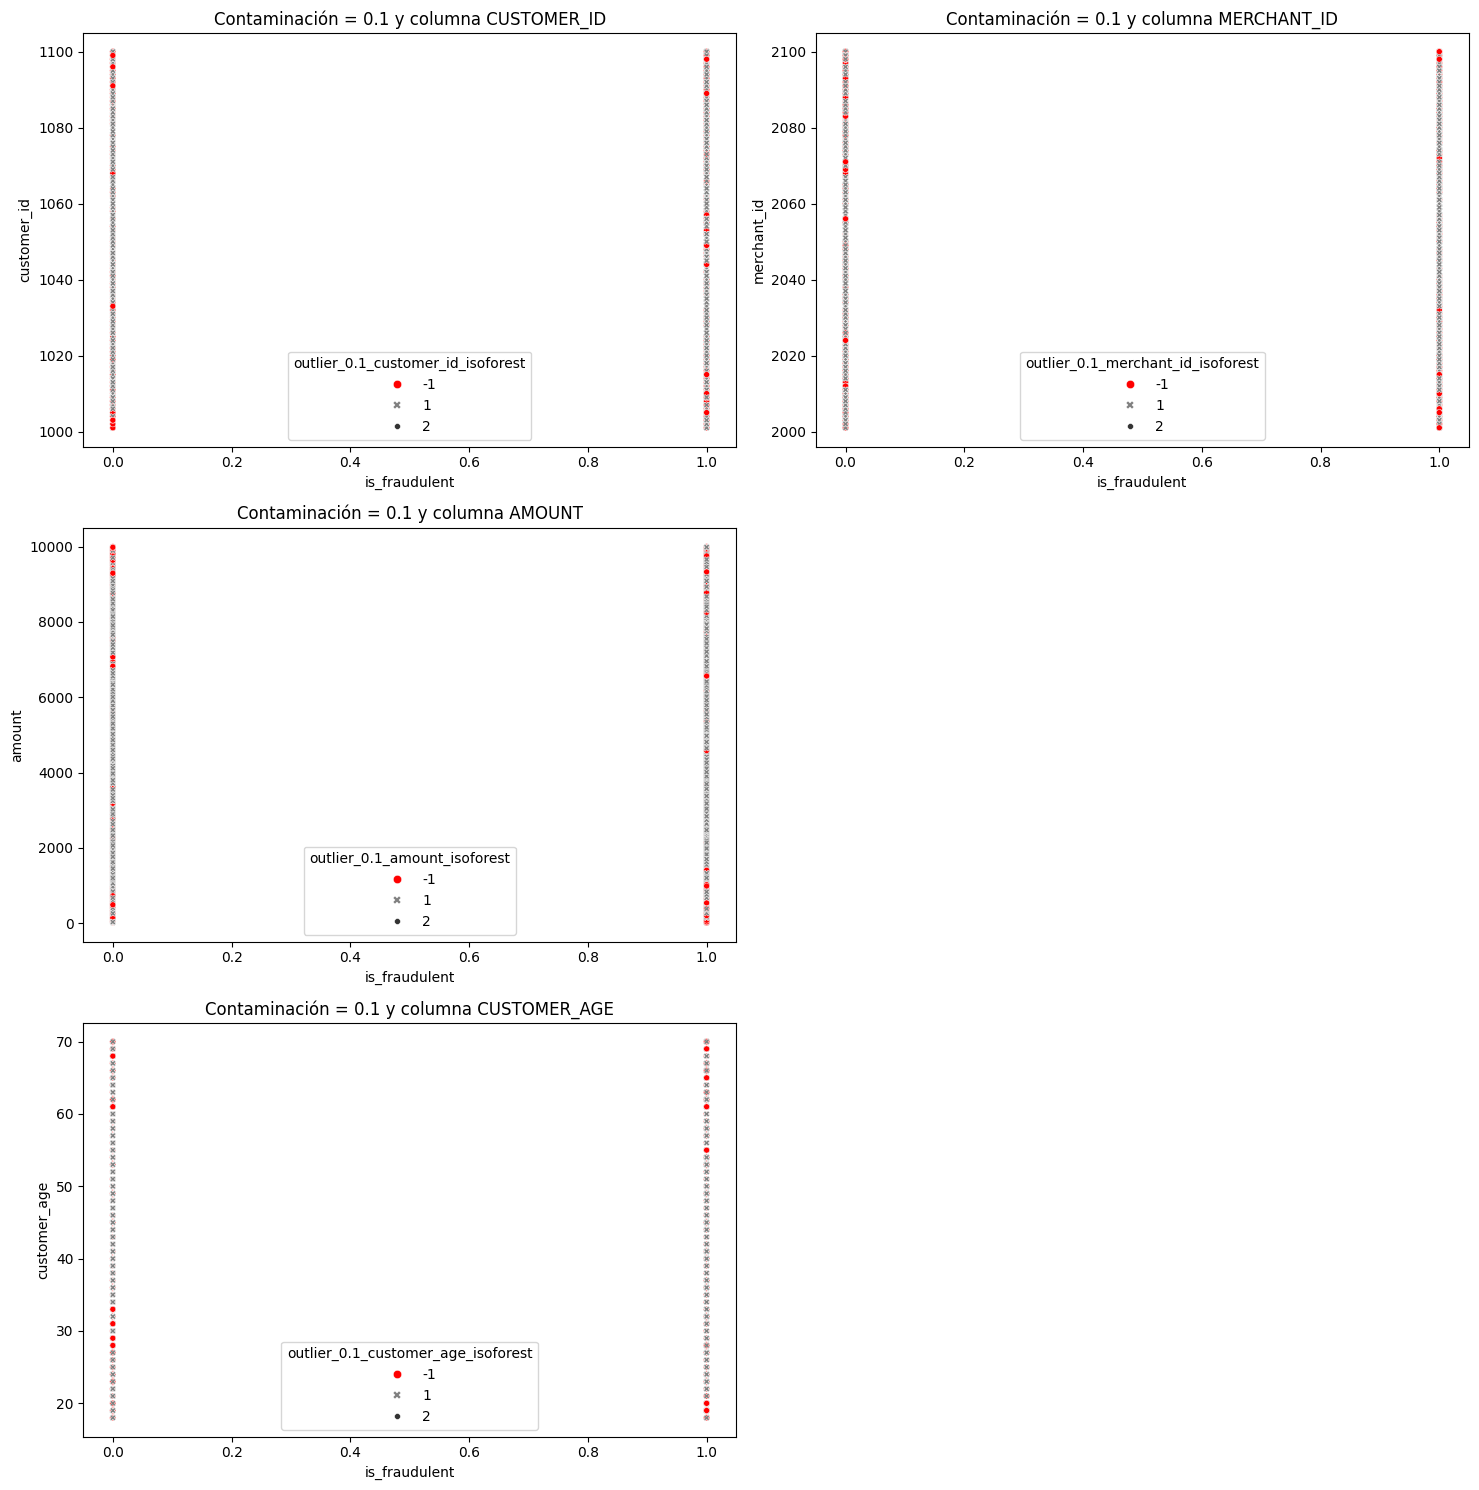

In [301]:
df_iso = explorar_outliers_if(df,df,"is_fraudulent",grafica_size=(15,15))

In [302]:
df_iso.sample()

,customer_id,merchant_id,amount,is_fraudulent,card_type,purchase_category,customer_age,outlier_0.01_customer_id_isoforest,outlier_0.01_merchant_id_isoforest,outlier_0.01_amount_isoforest,...,outlier_0.05_customer_id_isoforest,outlier_0.05_merchant_id_isoforest,outlier_0.05_amount_isoforest,outlier_0.05_is_fraudulent_isoforest,outlier_0.05_customer_age_isoforest,outlier_0.1_customer_id_isoforest,outlier_0.1_merchant_id_isoforest,outlier_0.1_amount_isoforest,outlier_0.1_is_fraudulent_isoforest,outlier_0.1_customer_age_isoforest
5320,1066,2039,8159.69,0,Visa,Online Shopping,61,1,1,1,...,1,1,1,1,1,1,1,1,1,1


# LOF

In [303]:
len(df_lof.filter(like="outlier_").columns)

36

In [304]:
# Generamos nueva columna
df_lof["tipo_outliers"] = 0

# Contamos cuantos -1 hay
for columna in df_lof.filter(like="outlier").columns:
    df_lof["tipo_outliers"] += (df_lof[columna] == -1).astype(int)

# Generamos el diccionario de condiciones y textos para reemplazar
condiciones = [
    df_lof["tipo_outliers"] == 0,
    df_lof["tipo_outliers"].between(1, 21,"both"),
    df_lof["tipo_outliers"].between(22, 35,"both"),
    df_lof["tipo_outliers"] == 36
]

textos = [
    "No es Outlier",
    "Improbable Outlier",
    "Probable Outlier",
    "Total Outlier"
]

# Reemplazamos la cuenta por el texto
df_lof["tipo_outliers"] = np.select(condiciones, textos, default="Unknown")

# Isolation Forest

In [305]:
len(df_iso.filter(like="outlier_").columns)

15

In [306]:
# Generamos nueva columna
df_iso["tipo_outliers"] = 0

# Contamos cuantos -1 hay
for columna in df_iso.filter(like="outlier").columns:
    df_iso["tipo_outliers"] += (df_iso[columna] == -1).astype(int)

# Generamos el diccionario de condiciones y textos para reemplazar
condiciones = [
    df_iso["tipo_outliers"] == 0,
    df_iso["tipo_outliers"].between(1, 9,"both"),
    df_iso["tipo_outliers"].between(10, 14,"both"),
    df_iso["tipo_outliers"] == 15
]

textos = [
    "No es Outlier",
    "Improbable Outlier",
    "Probable Outlier",
    "Total Outlier"
]

# Reemplazamos la cuenta por el texto
df_iso["tipo_outliers"] = np.select(condiciones, textos, default="Unknown")

# Eliminar columnas que ya no necesitamos
- Nos quitamos las columnas de los outliers, ya las hemos categorizado

In [307]:
df_lof.drop(columns=df_lof.filter(like="outlier_").columns,inplace=True)
df_iso.drop(columns=df_iso.filter(like="outlier_").columns,inplace=True)

# Comparamos Métodos
- Veremos que detecciones han hecho cada uno

In [308]:
df_lof["tipo_outliers"].value_counts().reset_index()

,tipo_outliers,count
0,No es Outlier,8569
1,Improbable Outlier,1151
2,Probable Outlier,241
3,Total Outlier,39


In [309]:
df_iso["tipo_outliers"].value_counts().reset_index()

,tipo_outliers,count
0,No es Outlier,9000
1,Improbable Outlier,500
2,Probable Outlier,400
3,Total Outlier,100


# No eliminamos outliers (LOF) ni nulificamos
- Nulificamos Total y Probable Outlier

In [310]:
# df_lof = df_lof[df_lof["tipo_outliers"] != "Total Outlier"]
# df_lof["tipo_outliers"].unique()
# df_lof.reset_index(drop=True,inplace=True)

In [311]:
cols_nulificar = ['customer_id', 'merchant_id', 'amount', 'customer_age']
for columna in cols_nulificar:
    #df_lof.loc[df_lof["tipo_outliers"] == "Improbable Outlier", columna] = np.nan
    #df_lof.loc[df_lof["tipo_outliers"] == "Total Outlier", columna] = np.nan
    #df_lof.loc[df_lof["tipo_outliers"] == "Probable Outlier", columna] = np.nan
    print(f"Se han vuelto nulos: {df_lof[columna].isnull().sum()} valores en {columna}")

Se han vuelto nulos: 0 valores en customer_id
Se han vuelto nulos: 0 valores en merchant_id
Se han vuelto nulos: 0 valores en amount
Se han vuelto nulos: 0 valores en customer_age


# Rellenamos los nulos con Random Forest en Iterative

In [312]:
df = df_lof.copy()

In [313]:
df.isnull().sum()

customer_id          0
merchant_id          0
amount               0
is_fraudulent        0
card_type            0
purchase_category    0
customer_age         0
tipo_outliers        0
dtype: int64

In [314]:
cols_nulificar = ['customer_id', 'merchant_id', 'amount', 'customer_age']
df_num = df[cols_nulificar]

# Random Forest
iterative_imputer = IterativeImputer(
    estimator=RandomForestRegressor(random_state=42),
    #max_iter=10,  # Número de iteraciones para ajustar los valores
    random_state=42
)

df_num_imputado = iterative_imputer.fit_transform(df_num)
df_num_sin_nulos = pd.DataFrame(df_num_imputado, columns=df_num.columns)
df_rf = df.copy()
df_rf[df_num.columns] = df_num_sin_nulos
df_rf[cols_nulificar].isnull().sum()


customer_id     0
merchant_id     0
amount          0
customer_age    0
dtype: int64

# Eliminamos "tipo_outliers"
- Ya la hemos utilizado como queríamos

In [315]:
df_rf.drop(columns=("tipo_outliers"),inplace=True)

In [316]:
df_rf.to_csv("datos/financial_data_iso_forest.csv",index=False)

In [317]:
df = pd.read_csv("datos/financial_data_iso_forest.csv")

3. **Transformación de variables:**

   - Normalizar o escalar variables numéricas según sea necesario.

   - Codificar variables categóricas con técnicas como One-Hot Encoding, Target Encoding u Ordinal Encoding, según corresponda.

   - Crear variables derivadas útiles, como:

     - Frecuencia de transacciones de cada cliente.

     - Diferencia de tiempo entre transacciones consecutivas.

     - Ratio entre el saldo posterior y el monto de la transacción.

# Encoding

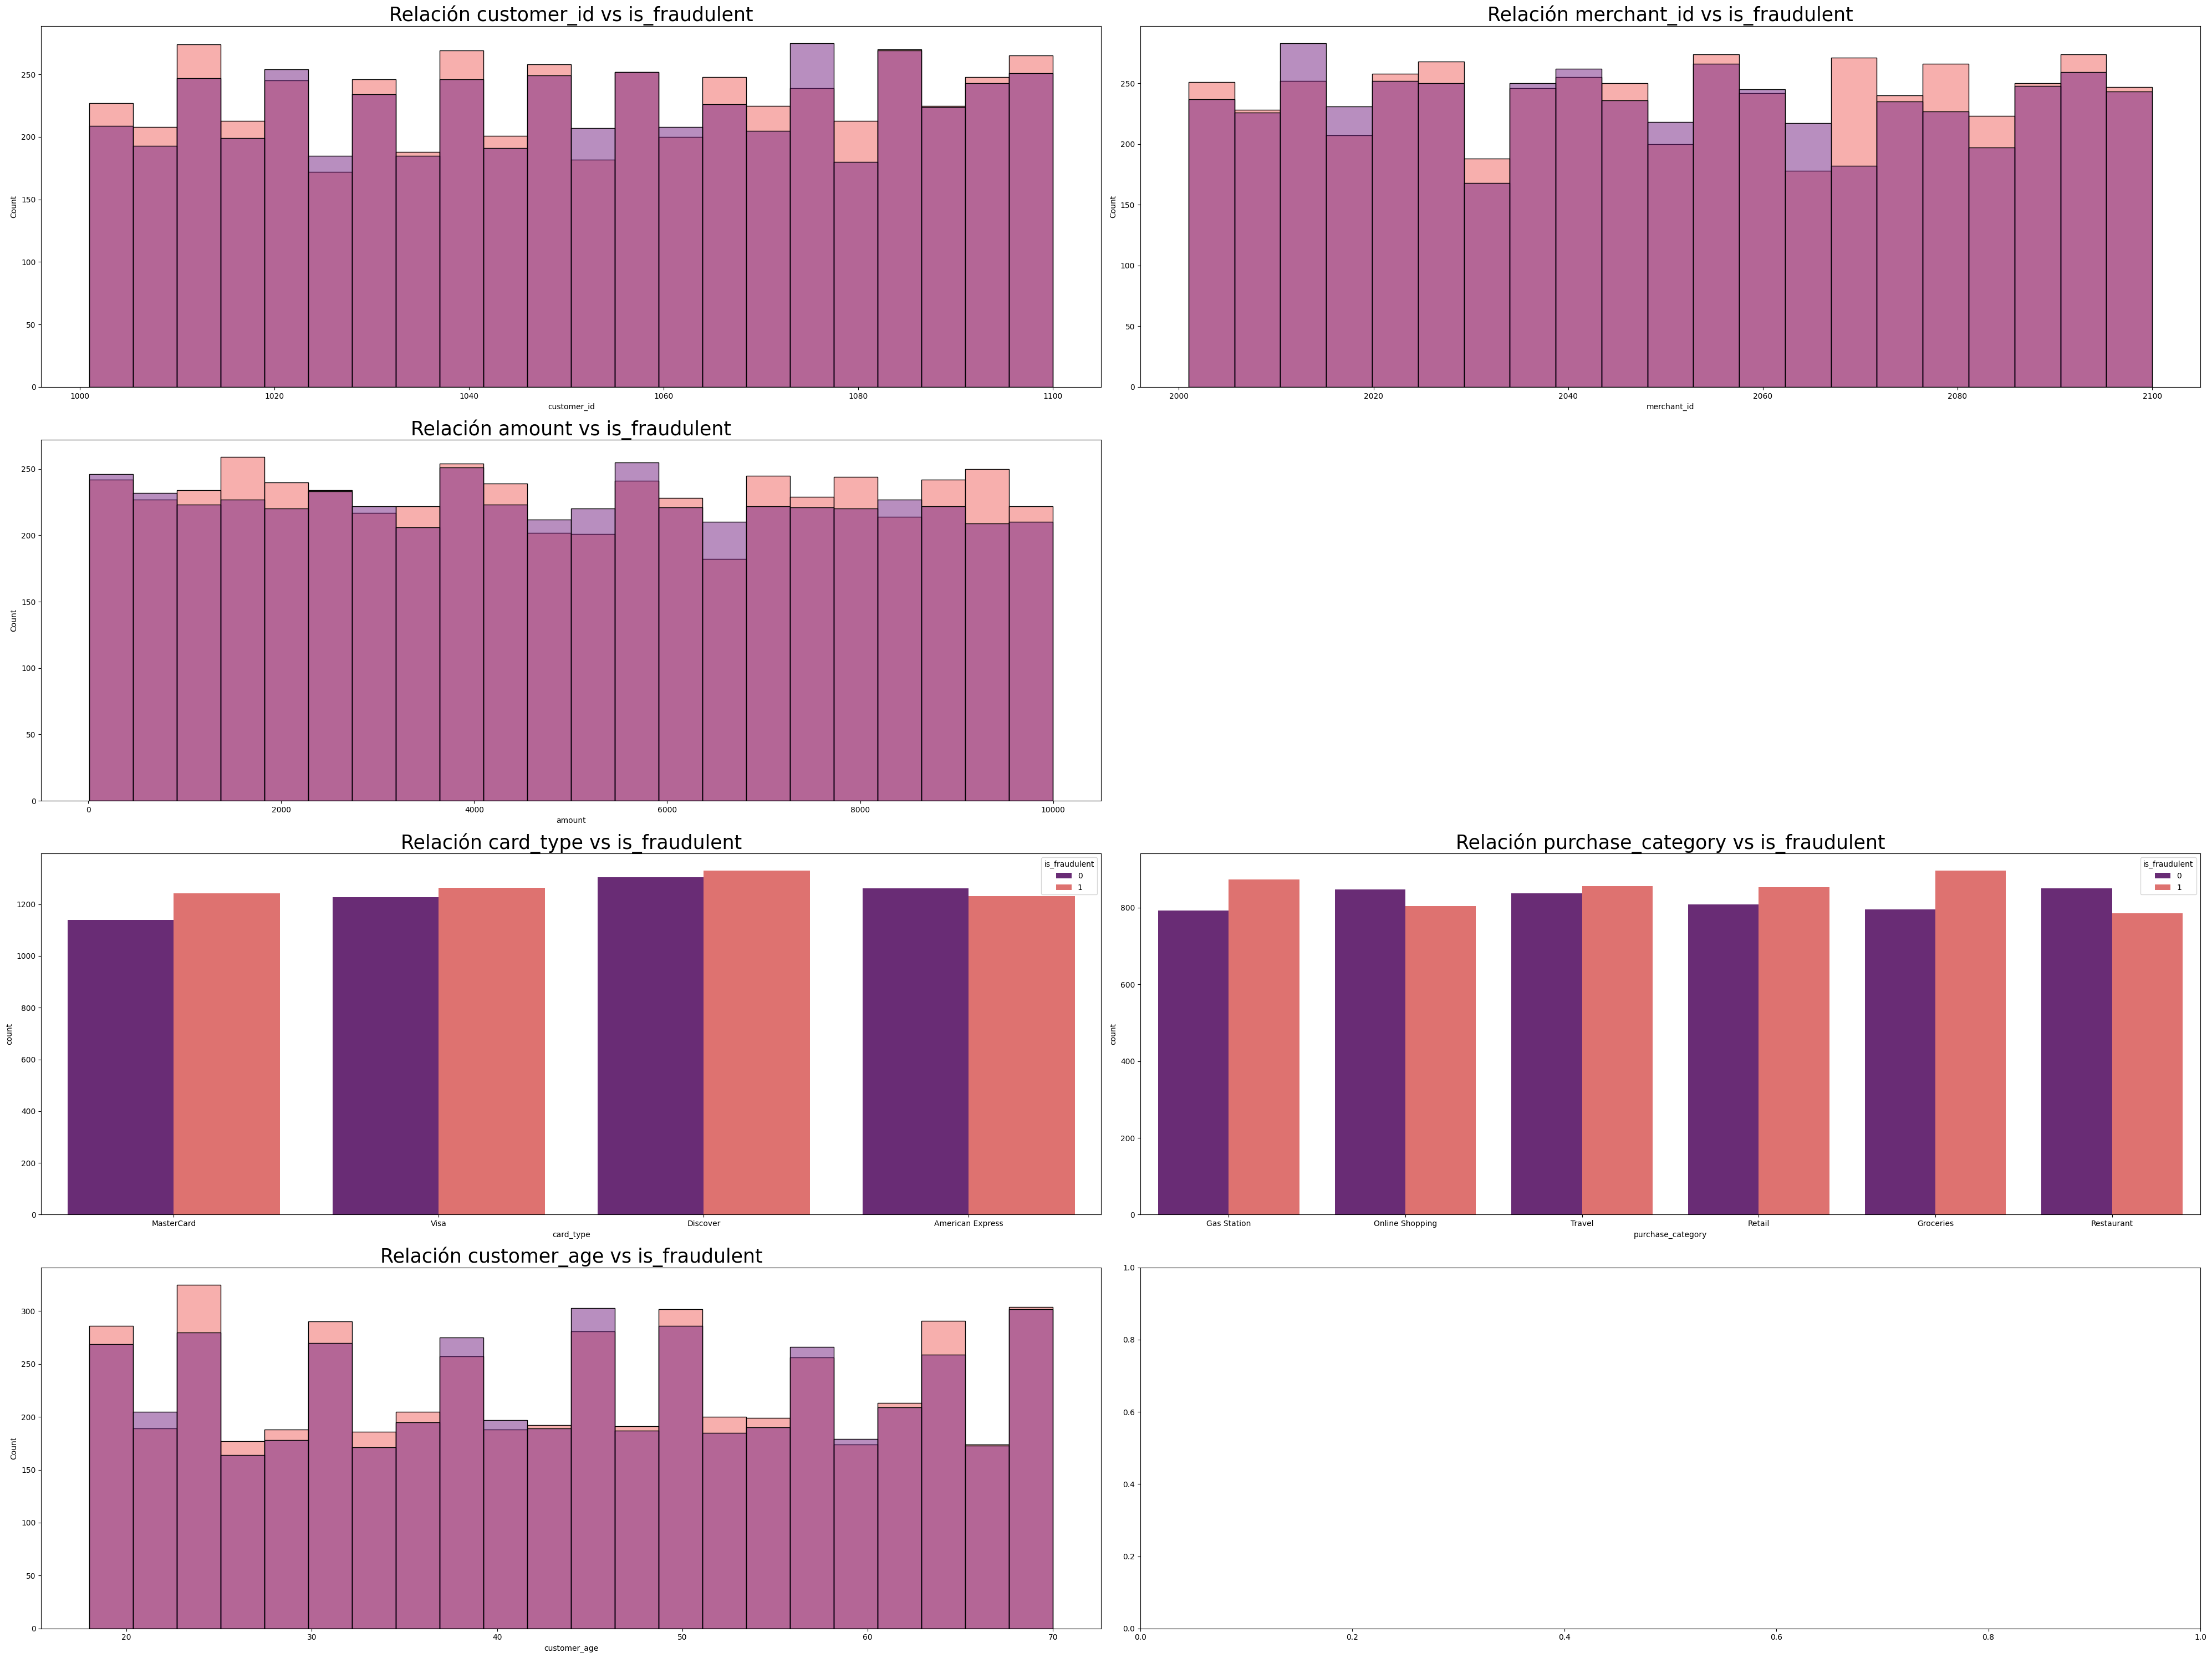

In [318]:
# Crear una instancia de la clase y llamar a los métodos
visualizador =sl.Visualizador(df)
# evaluamos la relación entre las variables independientes y dependientes
visualizador.plot_relacion(vr = "is_fraudulent",tamano_grafica=(40,30))

# Prueba de Chi cuadrado

In [319]:
# sacamos la lista de columnas categóricas
lista_col_categ = df.select_dtypes(include = ["O", "category"])

for columna in lista_col_categ:

    print(f"Analizando la relación entre IS_FRAUDULENT y {columna.upper()}")
    # Inicializar la clase
    analisis_chi2 = se.AnalisisChiCuadrado(df, variable_predictora = columna, variable_respuesta = 'is_fraudulent')

    # Generar la tabla de contingencia
    tabla_contingencia = analisis_chi2.generar_tabla_contingencia()

    # Realizar la prueba de Chi-cuadrado
    resultado_chi2 = analisis_chi2.realizar_prueba_chi_cuadrado()

    print("\n ##################################### \n")

Analizando la relación entre IS_FRAUDULENT y CARD_TYPE
Tabla de contingencia:


card_type,American Express,Discover,MasterCard,Visa
is_fraudulent,,,,
0,1262,1304,1140,1226
1,1232,1329,1243,1264



Resultado de la prueba de Chi-cuadrado:
Chi2: 3.7812082706660246, p-valor: 0.28607950351317196
El p-valor >= 0.05, no hay diferencias entre los grupos.

 ##################################### 

Analizando la relación entre IS_FRAUDULENT y PURCHASE_CATEGORY
Tabla de contingencia:


purchase_category,Gas Station,Groceries,Online Shopping,Restaurant,Retail,Travel
is_fraudulent,,,,,,
0,792,796,847,851,808,838
1,874,896,804,785,853,856



Resultado de la prueba de Chi-cuadrado:
Chi2: 13.291965751690256, p-valor: 0.020791075460818598
El p-valor < 0.05, parece que hay diferencias entre los grupos.

 ##################################### 



# Ordinales
- purchase_category
# Nominales
- card_type

# Ordinales

In [320]:
cols_ordinales = ["purchase_category"]

### Target Encoder

In [321]:
target_encoder = TargetEncoder(cols=cols_ordinales)
df = target_encoder.fit_transform(df,df[["is_fraudulent"]])

In [322]:
### Guardar el encoder en pickle
with open("datos/modelos-encoders/target_encoder.pkl", "wb") as f:
    pickle.dump(target_encoder,f)

# Nominales

In [323]:
cols_nominales = ["card_type"]

### One Hot Encoder

In [324]:
one_hot_encoder = OneHotEncoder(categories='auto', 
                        drop=None, 
                        sparse_output=True, 
                        dtype='float', 
                        handle_unknown='error')

# Ajustar el codificador a los datos y transformarlos
encoder_trans = one_hot_encoder.fit_transform(df[cols_nominales])

# lo siguiente que hacemos es convertir el objeto devuelto por el fit_transform a array para poder verlo
encoder_array = encoder_trans.toarray()

# usaremos el método '.get_feature_names_out()' para extraer el nombre de las columnas
nombre_columnas = one_hot_encoder.get_feature_names_out()

# creamos un DataFrame con los resultados obtenidos de la transformación
encoder_df = pd.DataFrame(encoder_array, columns = nombre_columnas)

# concatenamos estos resultados con el DataFrame original
df = pd.concat([df, encoder_df], axis = 1)

In [325]:
### Guardar el encoder en pickle
with open("datos/modelos-encoders/one_hot_encoder.pkl", "wb") as f:
    pickle.dump(one_hot_encoder,f)

# Eliminar columnas nominales
- Ya tenemos las columnas generadas y ya no nos aportan información

In [326]:
df.drop(columns=cols_nominales,inplace=True)

In [327]:
df.sample()

,customer_id,merchant_id,amount,is_fraudulent,purchase_category,customer_age,card_type_American Express,card_type_Discover,card_type_MasterCard,card_type_Visa
4556,1031.0,2007.0,9783.02,1,0.486978,22.0,1.0,0.0,0.0,0.0


# Featuring Scaling

# Vamos a usar MinMaxScaler
- Ya hemos gestionado los outliers

In [328]:
cols_escalar = ["customer_id","merchant_id","amount","purchase_category","customer_age"]
escalador_minmax = MinMaxScaler()
datos_transf_minmax = escalador_minmax.fit_transform(df[cols_escalar])
df_c = pd.DataFrame(datos_transf_minmax,columns=df[cols_escalar].columns)
df.drop(columns=cols_escalar, inplace=True)
df = pd.concat([df_c,df],axis=1)

In [329]:
with open("datos/modelos-encoders/minmax_scaler.pkl","wb") as f:
    pickle.dump(escalador_minmax, f)

In [330]:
df.to_csv("datos/03_financial_data_minmaxscaler.csv",index=False)